# Learning Protein-Peptide Proteome Structure for Missing Value Imputation

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
utils_path = '../..'
if utils_path not in sys.path:
    sys.path.append(utils_path)
from utils.embeddings import embed_sequences_t5

In [3]:
import random
import math
from pathlib import Path

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from pyproteonet.io import load_maxquant
from pyproteonet.processing import logarithmize
from pyproteonet.aggregation import maxlfq
from pyproteonet.simulation import simulate_mcars
from pyproteonet.normalization.simple import normalize_sum

PEPTIDE_IMPUTATION_METHODS = ['mindet', 'minprob', 'mean', 'missforest', 'bpca', 'isvd', 'vae', 'dae', 'cf', 'iterative']
PROTEIN_IMPUTATION_METHODS = ['mindet', 'minprob', 'mean', 'missforest', 'missforest_t', 'bpca', 'bpca_t', 'isvd', 'vae', 'dae', 'cf', 'iterative']

# Real-World Datasets

In [4]:
datasets = dict()

In [ ]:
#load breast cancer dataset
breast_cancer_ds = load_maxquant(peptides_table='~/fg_data/datasets/PXD035857_breast_cancer/peptides.txt',
                                 protein_groups_table='~/fg_data/datasets/PXD035857_breast_cancer/proteinGroups.txt')
random.seed(42)
sample_subset = random.sample(breast_cancer_ds.sample_names, 15)
print('creating subset of dataset containing samples: ' + str(sample_subset))
# We work on a random subset to keep things fast and manageable
bc_ds = breast_cancer_ds.copy(samples=sample_subset)
bc_ds = logarithmize(bc_ds)
# Rename molecules and columns for convenience
bc_ds.rename_molecule('protein_group', 'protein')
bc_ds.rename_mapping('peptide-protein_group', 'peptide-protein')
bc_ds.rename_columns(columns={'peptide':{'Intensity': 'abundance_gt'}}, inplace=True)
# Restrict to molecules having at least some non-missing peptide abundance values
df = bc_ds.get_wf('peptide', 'abundance_gt')
pep_mask = df[~df.isna().all(axis=1)].index
mapping = bc_ds.mappings['peptide-protein'].df
prot_mask = mapping[mapping.index.get_level_values('peptide').isin(pep_mask)].index.get_level_values('protein').unique()
bc_ds = bc_ds.copy(molecule_ids={'protein': prot_mask, 'peptide': pep_mask}, copy_molecule_set=True)

# Incorparate missing values
vals = bc_ds.values['peptide']['abundance_gt']
vals[vals.dropna().sample(frac=0.1).index] = np.nan
bc_ds.values['peptide']['abundance'] = vals
# a second aggregation is required to get the new protein intensities including new missing values
bc_ds.values['protein']['abundance_gt'] = maxlfq(dataset=bc_ds, molecule='protein', mapping='peptide-protein', partner_column='abundance_gt',
                                                 min_ratios=2, median_fallback=False, is_log=True)
bc_ds.values['protein']['abundance'] = maxlfq(dataset=bc_ds, molecule='protein', mapping='peptide-protein', partner_column='abundance',
                                              min_ratios=2, median_fallback=False, is_log=True)
datasets['breast_cancer'] = bc_ds

/hpi/fs00/home/tobias.pietz/MasterThesis/pyproteonet/pyproteonet/io/maxquant.py:43: DtypeWarning: Columns (438,439,447) have mixed types. Specify dtype option on import or set low_memory=False.
  peptides_table = pd.read_csv(peptides_table, sep="\t")
/hpi/fs00/home/tobias.pietz/MasterThesis/pyproteonet/pyproteonet/io/maxquant.py:56: DtypeWarning: Columns (1189,1190) have mixed types. Specify dtype option on import or set low_memory=False.
  protein_groups_table = pd.read_csv(protein_groups_table, sep="\t")


creating subset of dataset containing samples: ['33118', '33070', '38730', '38719', '38712', '33867', '33116', '33110', '39474', '33073', '33072', '33112', '38710', '38716', '38703']


/hpi/fs00/home/tobias.pietz/MasterThesis/pyproteonet/pyproteonet/aggregation/maxlfq.py:186: NumbaTypeSafetyWarning: unsafe cast from uint64 to int64. Precision may be lost.
  grouping = mask_group(groupings[group_idx])


In [ ]:
#load crohns dataset
from io_utils.datasets import load_crohns_disease_dataset
crohns_ds = load_crohns_disease_dataset()
crohns_ds = logarithmize(crohns_ds)
crohns_ds.rename_molecule('protein_group', 'protein')
crohns_ds.rename_mapping(mapping='peptide-protein_group', new_name='peptide-protein')
crohns_ds.rename_columns(columns={'peptide':{'Intensity': 'abundance_gt'}}, inplace=True)
# Incorparate missing values
vals = crohns_ds.values['peptide']['abundance_gt']
vals[vals.dropna().sample(frac=0.1).index] = np.nan
crohns_ds.values['peptide']['abundance'] = vals
# a second aggregation is required to get the new protein intensities including new missing values
crohns_ds.values['protein']['abundance_gt'] = maxlfq(dataset=crohns_ds, molecule='protein', mapping='peptide-protein', partner_column='abundance_gt',
                                                     min_ratios=2, median_fallback=False, is_log=True)
crohns_ds.values['protein']['abundance'] = maxlfq(dataset=crohns_ds, molecule='protein', mapping='peptide-protein', partner_column='abundance',
                                                  min_ratios=2, median_fallback=False, is_log=True)
datasets['crohns'] = crohns_ds

/hpi/fs00/home/tobias.pietz/MasterThesis/results/outlook2/../../io_utils/datasets.py:236: DtypeWarning: Columns (330) have mixed types. Specify dtype option on import or set low_memory=False.
  peptide_df = pd.read_csv(base_path / 'peptides.txt', sep='\t')
/hpi/fs00/home/tobias.pietz/MasterThesis/results/outlook2/../../io_utils/datasets.py:237: DtypeWarning: Columns (399,400) have mixed types. Specify dtype option on import or set low_memory=False.
  protein_df = pd.read_csv(base_path / 'proteinGroups.txt', sep='\t')


In [7]:
#load prostate cancer dataset
prostate_ds = load_maxquant(peptides_table='~/fg_data/datasets/PXD029525_prostate_cancer/peptides.txt',
                            protein_groups_table='~/fg_data/datasets/PXD029525_prostate_cancer/proteinGroups.txt')
prostate_ds = logarithmize(prostate_ds)
# Rename molecules and columns for convenience
prostate_ds.rename_molecule('protein_group', 'protein')
prostate_ds.rename_mapping('peptide-protein_group', 'peptide-protein')
prostate_ds.rename_columns(columns={'peptide':{'Intensity': 'abundance_gt'}}, inplace=True)
# Restrict to molecules having at least some non-missing peptide abundance values
df = prostate_ds.get_wf('peptide', 'abundance_gt')
pep_mask = df[~df.isna().all(axis=1)].index
mapping = prostate_ds.mappings['peptide-protein'].df
prot_mask = mapping[mapping.index.get_level_values('peptide').isin(pep_mask)].index.get_level_values('protein').unique()
prostate_ds = prostate_ds.copy(molecule_ids={'protein': prot_mask, 'peptide': pep_mask}, copy_molecule_set=True)

# For evaluation purposes we introduce 10% of missing values (MCAR)
#simulate_mcars(dataset=prostate_ds, molecule='peptide', column='abundance_gt', result_column='abundance', amount=0.1, inplace=True)
vals = prostate_ds.values['peptide']['abundance_gt']
vals[vals.dropna().sample(frac=0.1).index] = np.nan
prostate_ds.values['peptide']['abundance'] = vals
# a second aggregation is required to get the new protein intensities including new missing values
prostate_ds.values['protein']['abundance_gt'] = maxlfq(dataset=prostate_ds, molecule='protein', mapping='peptide-protein', partner_column='abundance_gt',
                                                       min_ratios=2, median_fallback=False, is_log=True)
prostate_ds.values['protein']['abundance'] = maxlfq(dataset=prostate_ds, molecule='protein', mapping='peptide-protein', partner_column='abundance',
                                                    min_ratios=2, median_fallback=False, is_log=True)
datasets['prostate_cancer'] = prostate_ds

/hpi/fs00/home/tobias.pietz/MasterThesis/pyproteonet/pyproteonet/io/maxquant.py:56: DtypeWarning: Columns (174) have mixed types. Specify dtype option on import or set low_memory=False.
  protein_groups_table = pd.read_csv(protein_groups_table, sep="\t")
/hpi/fs00/home/tobias.pietz/MasterThesis/pyproteonet/pyproteonet/aggregation/maxlfq.py:186: NumbaTypeSafetyWarning: unsafe cast from uint64 to int64. Precision may be lost.
  grouping = mask_group(groupings[group_idx])


NameError: name 'datasets' is not defined

In [100]:
from io_utils.datasets import load_maxlfqbench

#Load MaxLFQ ratio dataset, normalize using human proteins, calculate top3
maxlfq_bench = load_maxlfqbench()
#we use the intensity column as abundance
maxlfq_bench.values['peptide']['abundance'] = maxlfq_bench.values['peptide']['Intensity']

#Extract organism from fasta headers
maxlfq_bench.rename_molecule('protein_group', 'protein')
maxlfq_bench.rename_mapping('peptide-protein_group', 'peptide-protein')
prots = maxlfq_bench.molecules['protein']
maxlfq_bench.molecules['protein']['is_human'] = prots['Fasta headers'].str.contains('HUMAN')
maxlfq_bench.molecules['protein']['is_ecoli'] = prots['Fasta headers'].str.contains('ECOLI')
#Propagate the organism information to peptide level
mapped = maxlfq_bench.molecule_set.get_mapped(molecule='protein', mapping='peptide-protein', molecule_columns='is_ecoli')
grouped = mapped.groupby('peptide').is_ecoli.mean()
grouped = grouped[(grouped==0) | (grouped==1)]
maxlfq_bench.molecules['peptide']['is_ecoli'] = False
maxlfq_bench.molecules['peptide'].loc[grouped.index, 'is_ecoli'] = grouped.astype(bool)
maxlfq_bench.molecules['peptide']['is_human'] = False
maxlfq_bench.molecules['peptide'].loc[grouped.index, 'is_human'] = ~grouped.astype(bool)
human_peps = maxlfq_bench.molecules['peptide']['is_human']
human_peps = human_peps[human_peps].index

_ = normalize_sum(dataset=maxlfq_bench, molecule='peptide', column='Intensity', result_column='abundance', reference_ids=human_peps)
maxlfq_bench = logarithmize(maxlfq_bench)
maxlfq_bench.rename_columns(columns={'peptide':{'abundance': 'abundance_gt'}}, inplace=True)
# Restrict to molecules having at least some non-missing peptide abundance values
df = maxlfq_bench.get_wf('peptide', 'abundance_gt')
pep_mask = df[~df.isna().all(axis=1)].index
mapping = maxlfq_bench.mappings['peptide-protein'].df
prot_mask = mapping[mapping.index.get_level_values('peptide').isin(pep_mask)].index.get_level_values('protein').unique()
maxlfq_bench = maxlfq_bench.copy(molecule_ids={'protein': prot_mask, 'peptide': pep_mask}, copy_molecule_set=True)

vals = maxlfq_bench.values['peptide']['abundance_gt']
vals[vals.dropna().sample(frac=0.1).index] = np.nan
maxlfq_bench.values['peptide']['abundance'] = vals
datasets['maxlfq_bench'] = maxlfq_bench

datasets['maxlfq_bench'].values['protein']['abundance'] = maxlfq(dataset=datasets['maxlfq_bench'], molecule='protein', mapping='peptide-protein', partner_column='abundance',
                                                                 min_ratios=2, median_fallback=False, is_log=True)
# tmp = Dataset.load('gt/maxlfq_bench')
# datasets['maxlfq_bench'].molecules['peptide']['embedding'] = tmp.molecules['peptide'].loc[datasets['maxlfq_bench'].molecules['peptide'].index, 'embedding']

In [ ]:
#Plot the ratios to check whether we get two clusters (for human with log ratio around 0 and e. coli with log ratio around 1)
vals = datasets['maxlfq_bench'].get_values_flat('protein', molecule_columns='is_human')
vals['is_low'] = vals.index.get_level_values('sample').str.contains('L')
high, low = tuple([group.droplevel('is_low') for _,group in vals.groupby(['id', 'is_low']).median().groupby('is_low')])
h_ecoli = high[~high.is_human.astype(bool)]
l_ecoli = low[~low.is_human.astype(bool)]
ecoli_median = (h_ecoli-l_ecoli).median()['abundance']
h_human = high[high.is_human.astype(bool)]
l_human = low[low.is_human.astype(bool)]
fig, ax = plt.subplots()
ax.scatter((h_human-l_human)['abundance'], ((h_human + l_human)['abundance'] / 2), s=3, label='Human')
ax.scatter((h_ecoli-l_ecoli)['abundance'], ((h_ecoli + l_ecoli)['abundance'] / 2), s=3, label='E. coli')
ax.legend()
human_median = h_human.median()['abundance']-l_human.median()['abundance']
print(f'E.coli ratio dist: {math.e**ecoli_median}')
print(f'human ecoli ratio dist: {math.e**(ecoli_median - human_median)}')

In [6]:
from io_utils.datasets import load_ecoliddadiabench

data_path = Path('/hpi/fs00/home/tobias.pietz/fg_data/')
ecoli_dda_dia = load_ecoliddadiabench(base_path = data_path / 'EcoliDdaDiaBench_PXD018408')
ecoli_dda_dia.values['peptide']['abundance'] = ecoli_dda_dia.values['peptide']['intensity_normalized']
gt_dia = ecoli_dda_dia.values['peptide']['gt_dia']
ecoli_dda_dia.values['peptide']['abundance_dia']  = gt_dia * (ecoli_dda_dia.values['peptide']['abundance'].mean() / gt_dia.mean())
ecoli_dda_dia = logarithmize(ecoli_dda_dia)
datasets['ecoli_dda_dia'] = ecoli_dda_dia

In [35]:
from io_utils.datasets import load_steen_blood

steen_blood_dda = load_steen_blood(base_path= data_path / 'SteenLab_DDA_MBR_ON')
steen_blood_dia = load_steen_blood(base_path=data_path / 'SteenLab_DIA_MBR_ON')
steen_pep_dia = steen_blood_dia.values['peptide']['abundance']
steen_blood_dia.values['peptide']['abundance']  = steen_pep_dia * (steen_blood_dda.values['peptide']['abundance'].mean() / steen_pep_dia.mean())
steen_blood_dda = logarithmize(steen_blood_dda)
steen_blood_dia = logarithmize(steen_blood_dia)
steen_blood_dda.set_column_lf(molecule='peptide', column='abundance_dia', values=steen_blood_dia.values['peptide']['abundance'], skip_foreign_ids=True)
datasets['steen_blood'] = steen_blood_dda

# Imputation with Standard Methods

Imputing steen_blood


  0%|          | 0/10 [00:00<?, ?it/s]

Imputing with method mindet, storing results in value column mindet
Imputing with method minprob, storing results in value column minprob
[1] 0.484171
Imputing with method mean, storing results in value column mean
Imputing with method missforest, storing results in value column missforest
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Imputing with method bpca, storing results in value column bpca
Imputing with method isvd, storing results in value column isvd
[IterativeSVD] Iter 1: observed MAE=1.770164
[IterativeSVD] Iter 2: observed MAE=0.743431
[IterativeSVD] Iter 3: observed MAE=0.482430
[IterativeSVD] Iter 4: observed MAE=0.409201
[IterativeSVD] Iter 5: observed MAE=0.373622
[IterativeSVD] Iter 6: observed MAE=0.353497
[IterativeSVD] Iter 7: observed MAE=0.340888
[IterativeSVD] Iter 8: observed MAE=0.332462
[IterativeSVD] Iter 9: observed MAE=0.326453
[IterativeSVD] Iter 10: observed MAE=0.322011
[IterativeSVD

epoch,train_loss,valid_loss,time
0,2063.690186,228.430740,00:00
1,2066.819336,227.486237,00:00
2,2063.733398,228.714600,00:00
3,2063.753174,227.504745,00:00
4,2061.192139,229.918686,00:00
5,2060.812012,229.406143,00:00
6,2058.523438,228.652817,00:00
7,2055.626709,227.282578,00:00
8,2052.117432,223.884659,00:00
9,2047.473877,225.340683,00:00


Imputing with method dae, storing results in value column dae


epoch,train_loss,valid_loss,time
0,23098.447266,2439.246338,00:00
1,23104.246094,2437.427246,00:00
2,22957.005859,2434.275879,00:00
3,22806.199219,2428.625977,00:00
4,22568.748047,2418.366699,00:00
5,22255.376953,2403.894043,00:00
6,21873.167969,2382.493164,00:00
7,21418.982422,2346.954102,00:00
8,20879.871094,2292.338135,00:00
9,20284.781250,2211.324219,00:00


Imputing with method cf, storing results in value column cf


suggested_lr.valley = 0.00437


epoch,train_loss,valid_loss,time
0,2.394874,None,00:00
1,2.377837,None,00:00
2,2.352260,None,00:00
3,2.311043,None,00:00
4,2.243172,None,00:00
5,2.144190,None,00:00
6,2.014653,None,00:00
7,1.859370,None,00:00
8,1.694311,None,00:00
9,1.534574,None,00:00


(22146, 1)


(38025,)
Imputing with method iterative, storing results in value column iterative


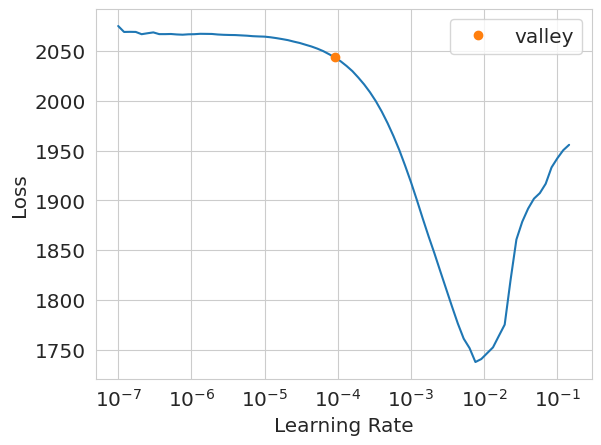

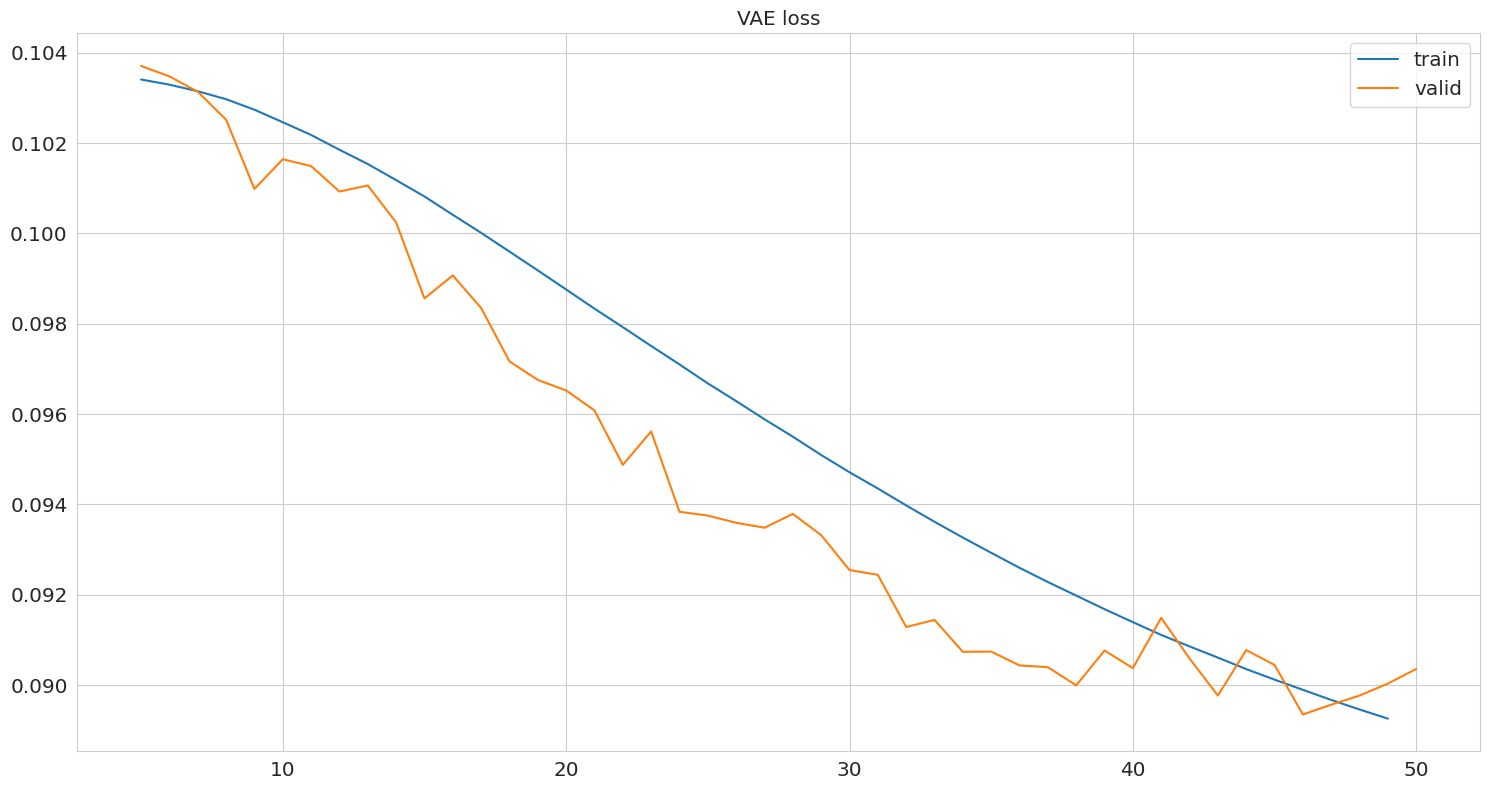

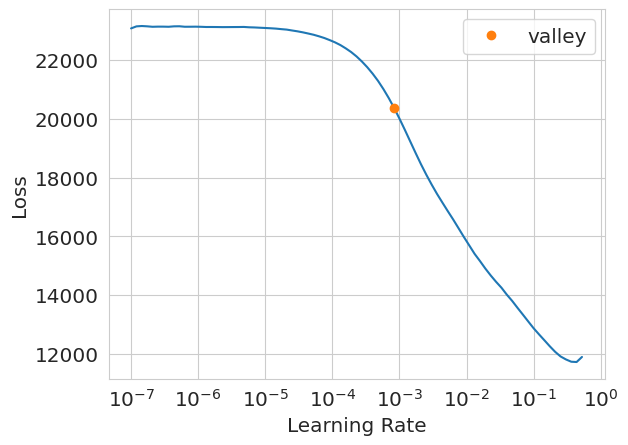

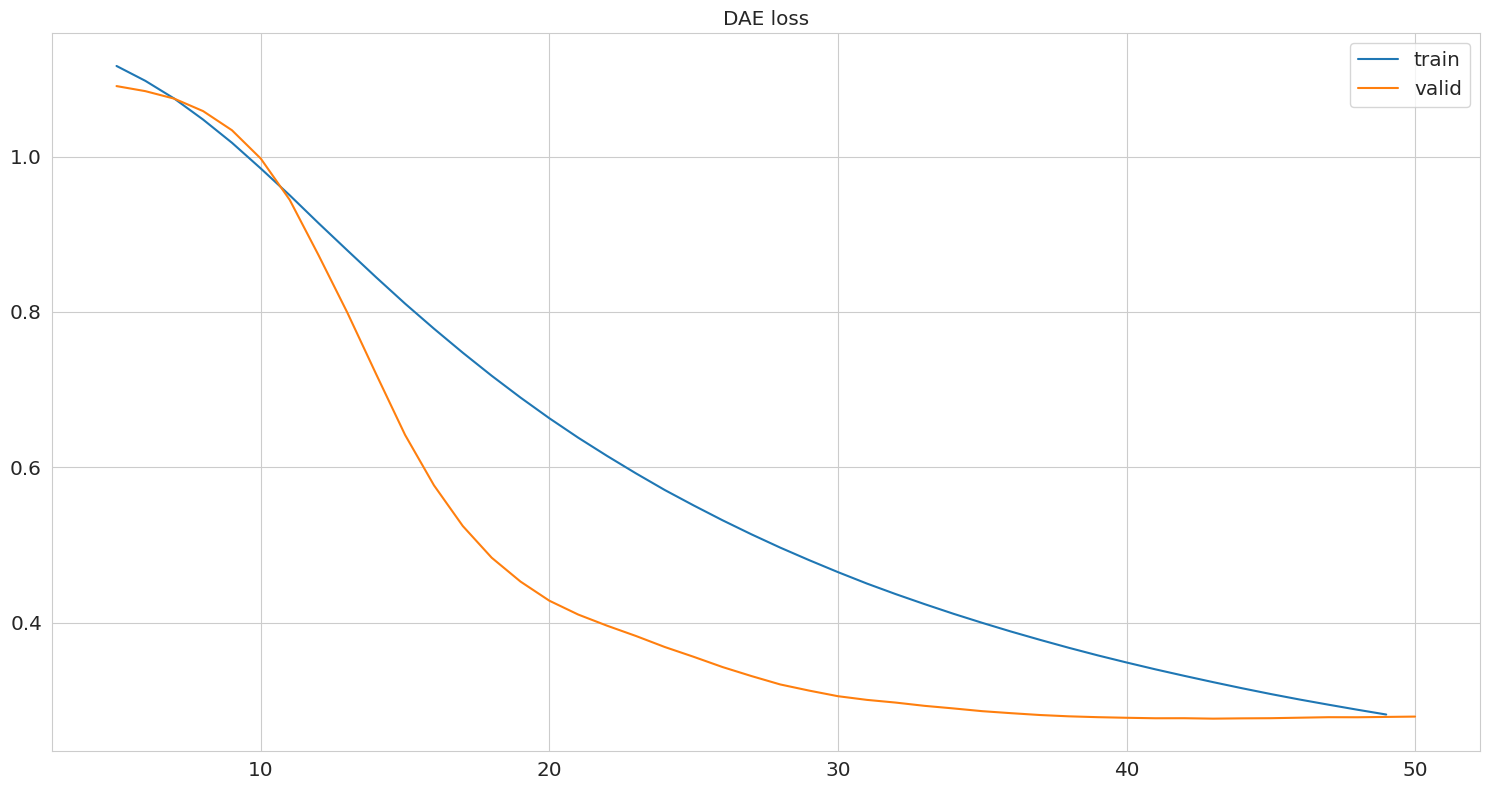

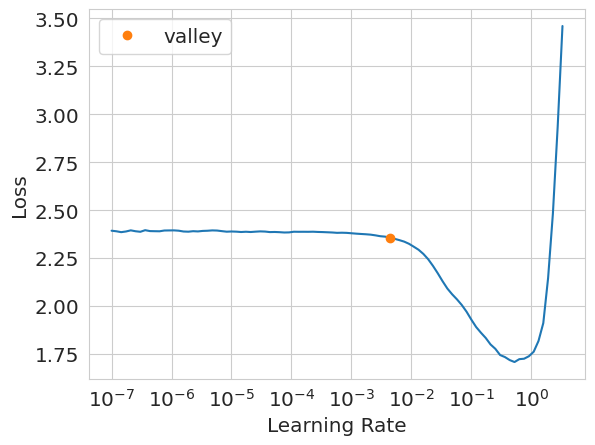

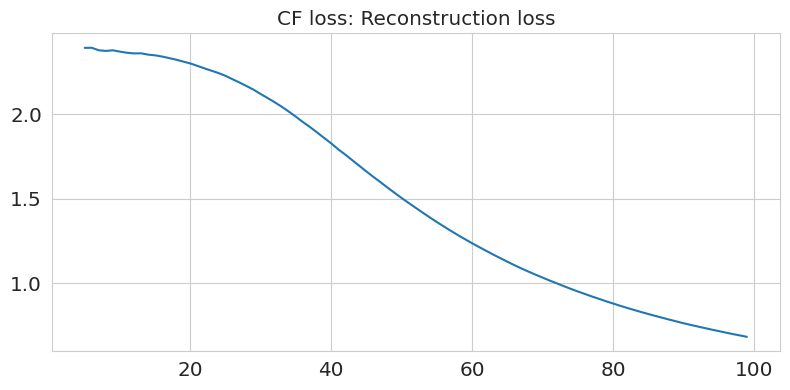

In [36]:
from pyproteonet.imputation.high_level_api import impute_molecule

runtimes_pep = dict()
runtimes_prot = dict()
for ds_name, ds in datasets.items():
    print('Imputing ' + ds_name)
    runtimes_pep[ds_name] = impute_molecule(dataset=ds, molecule='peptide', column='abundance', methods=PEPTIDE_IMPUTATION_METHODS)
    #runtimes_prot[ds_name] = impute_molecule(dataset=ds, molecule='protein', column='abundance', methods=PROTEIN_IMPUTATION_METHODS)

# Saving and Loading

In [46]:
for ds_name, ds in datasets.items():
    ds.save(f'data_imp/{ds_name}', overwrite=True)

In [103]:
import json
from pathlib import Path

runtimes_pep_path = Path('runtimes') / 'runtimes_pep.json'
if runtimes_pep_path.exists():
    with open(runtimes_pep_path, 'r') as f:
        runtimes_pep_loaded = json.load(f)
else:
    runtimes_pep_loaded = dict()
for ds_name, runtimes in runtimes_pep.items():
    if ds_name not in runtimes_pep_loaded:
        runtimes_pep_loaded[ds_name] = {}
    for method, rt in runtimes.items():
        runtimes_pep_loaded[ds_name][method] = rt
with open(runtimes_pep_path, 'w') as f:
    json.dump(runtimes_pep_loaded, f)

In [1]:
from pyproteonet.data import Dataset
datasets = {}
for ds_name in ['breast_cancer', 'crohns', 'prostate_cancer', 'maxlfq_bench', 'ecoli_dda_dia', 'steen_blood']:
    # if ds_name == 'crohns':
    #     datasets['crohns'] = Dataset.load('../masking/data_var/rep_0/MaxLFQ/crohns/')
    # else:
    datasets[ds_name] = Dataset.load(f'data_imp/{ds_name}')

In [22]:
for ds_name, ds in datasets.items():
    df = ds.molecules['peptide']
    sequ = df.sequence if 'sequence' in df else df['Sequence']
    #print(ds_name, sequ)
    wf = ds.get_wf('peptide', 'abundance')
    print(ds_name)
    print(wf.isna().all(axis=1).sum() / wf.shape[0])
    print(sequ.duplicated().sum())

breast_cancer
0.02879480417092926
0
crohns
0.015676329894530574
0
prostate_cancer
0.0052509253679951795
0
maxlfq_bench
0.005307561294411217
0
ecoli_dda_dia
0.0
0
steen_blood
0.0
0


In [13]:
import pandas as pd

In [16]:
pd.Series([1,2,2,3,4]).duplicated().sum()

1

0

In [15]:
for ds_name, ds in datasets.items():
    sequences = ds.molecules['peptide']['Sequence']
    embeddings = embed_sequences_t5(sequences, batch_size=128)
    ds.molecules['peptide']['embedding'] = embeddings

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thouroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


  0%|          | 0/395 [00:00<?, ?it/s]

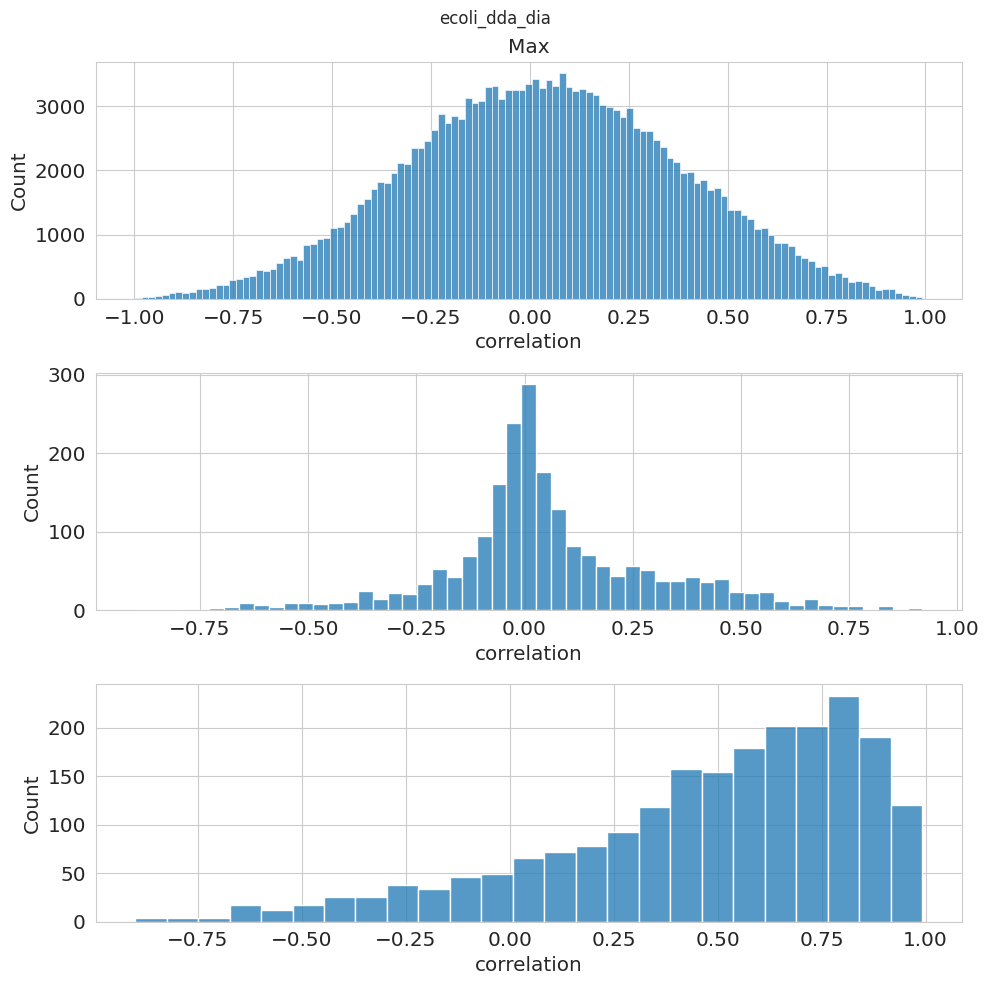

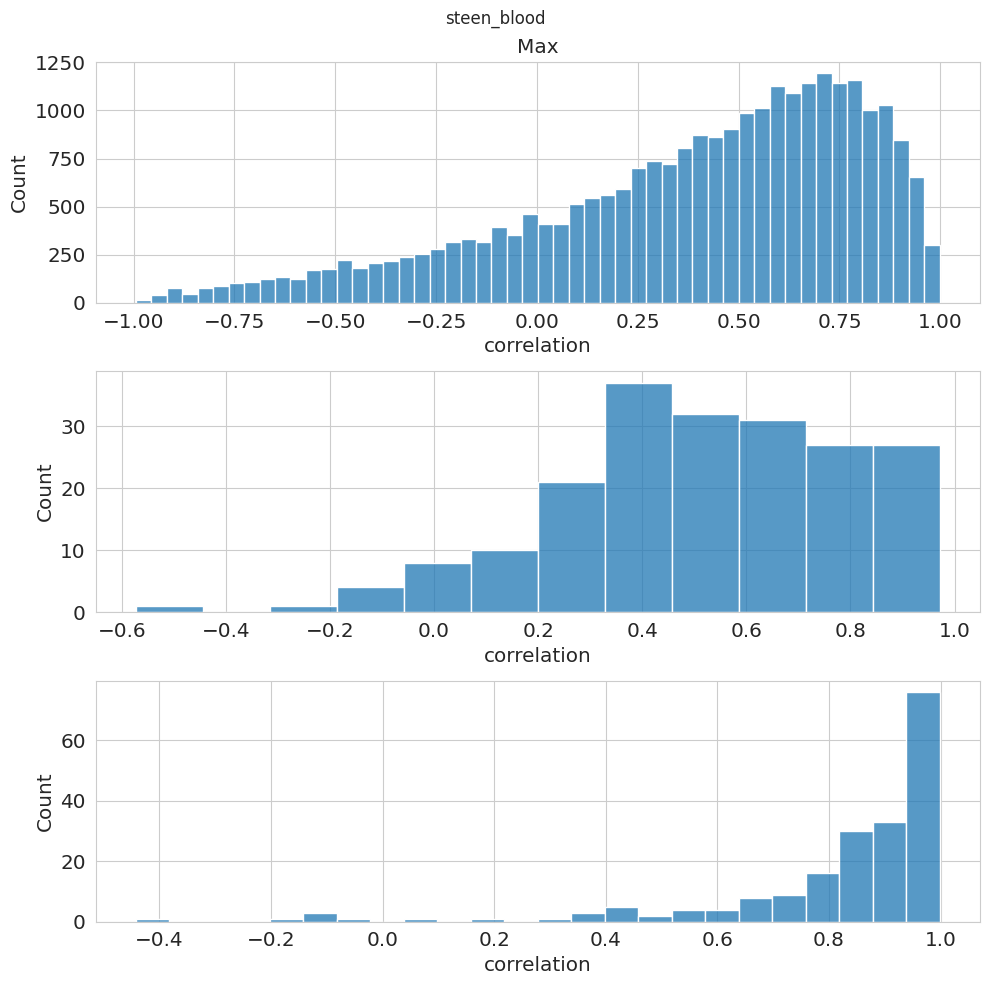

In [43]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

for ds_name, ds in datasets.items():
    mapped = ds.get_mapped('protein', mapping='peptide-protein', partner_columns=['abundance'])
    res = []
    indices = []
    i = 0
    for prot, prot_group in mapped.groupby('protein'):
        corrs = prot_group.unstack('peptide').corr(min_periods=5).values
        #corrs = corrs.droplevel(0, axis=1)
        #.corr().values
        corrs[corrs == 1] = 0
        res.extend(corrs.flatten())
        indices.extend([i] * corrs.flatten().shape[0])
        i += 1
    res = pd.DataFrame({'correlation': res, 'protein': indices})
    res = res[(res.correlation != 0) & ~res.correlation.isna()]
    fig, axs = plt.subplots(3, 1, figsize=(10, 10))
    sns.histplot(res.correlation, ax=axs[0])
    axs[0].set_title('All')
    sns.histplot(res.groupby('protein').mean().correlation, ax=axs[1])
    axs[0].set_title('Mean')
    sns.histplot(res.groupby('protein').max().correlation, ax=axs[2])
    axs[0].set_title('Max')
    fig.suptitle(ds_name)
    fig.tight_layout()
# res = res[~np.isnan(res)]
# res = res[res != 0]
#np.nanmean(res[res!=0])

In [24]:
data = {
    '#Peptides': [],
    '#Proteins': [],
    '#Samples': [],
    '% Missing Values': []
}
for ds_name, ds in datasets.items():
    perc_missing = ds.values['peptide']['abundance']
    num_peps = ds.molecules['peptide'].shape[0]
    num_prots = ds.molecules['protein'].shape[0]
    num_samples = ds.num_samples
    perc_missing = perc_missing.isna().sum() / perc_missing.shape[0]
    data['#Peptides'].append(num_peps)
    data['#Proteins'].append(num_prots)
    data['#Samples'].append(num_samples)
    data['% Missing Values'].append(perc_missing * 100)
pd.DataFrame(data, index=datasets.keys())

,#Peptides,#Proteins,#Samples,% Missing Values
breast_cancer,106547,13686,15,69.686742
crohns,34702,4169,31,66.710202
prostate_cancer,58085,4901,18,54.258127
maxlfq_bench,50494,6690,6,22.412564
ecoli_dda_dia,16400,3045,16,25.200076
steen_blood,2535,417,15,41.759369


# Graph Neural Network Imputation (Peptide-Peptide Graph connection Peptides of same Protein, T4 Peptide Sequence Embeddings)

In [42]:
ds = datasets['steen_blood']
sequences = ds.molecules['peptide'].sequence
embeddings = embed_sequences_t5(sequences, batch_size=128)
ds.molecules['peptide']['embedding'] = embeddings

  0%|          | 0/20 [00:00<?, ?it/s]

## Implement GNN Model and Imputation Method

In [20]:
import torch
from torch import nn
import lightning as L
from dgl.nn.pytorch.conv import GATv2Conv
from dgl.nn.pytorch import HeteroGraphConv
from dgl.dataloading import GraphCollator

class ImputationModule(L.LightningModule):
    def __init__(self, num_samples: int, num_proteins: int, num_peptides: int, loss_fn: str = 'mse'):
        super().__init__()
        # Four fully connected layers applied on the peptide input across samples
        prot_embedding_dim = 4 * num_samples
        pep_embedding_dim = 1024
        bottleneck_dim = 2 * num_samples
        lat_dim = 128
        dropout = 0.0
        heads = 64
        gat_dim = num_samples // 2
        self.emb_transform = nn.Sequential(nn.Dropout(0.0), nn.Linear(1024, 32), nn.LeakyReLU(), nn.Linear(32, 16))
        self.pep_fully_connected = nn.Sequential(nn.Linear(num_samples + 16, lat_dim), nn.LeakyReLU(),
                                                 #nn.Linear(lat_dim, lat_dim), nn.Dropout(dropout), nn.LeakyReLU(),
                                                 nn.Linear(lat_dim, lat_dim), nn.Dropout(dropout), nn.LeakyReLU(),
                                                 nn.Linear(lat_dim, lat_dim), nn.LeakyReLU(),
                                                 #nn.Linear(lat_dim, lat_dim), nn.Dropout(dropout), nn.LeakyReLU(),
                                                 nn.Linear(lat_dim, lat_dim))
        # Learnable protein embedding
        #self.prot_embedding = nn.Embedding(num_proteins, prot_embedding_dim)
        #self.pep_embedding = nn.Embedding(num_peptides, pep_embedding_dim)
        # Three GATv2 layers for utilizing the protein-peptides relations
        self.pep_pep_gat = HeteroGraphConv({'peptide-peptide': GATv2Conv(in_feats=(lat_dim, lat_dim), out_feats=gat_dim, feat_drop=0, num_heads=heads,)})
        #self.pep_pep_gat2 = HeteroGraphConv({'peptide-peptide': GATv2Conv(in_feats=(gat_dim + lat_dim, gat_dim + lat_dim), out_feats=gat_dim, feat_drop=dropout, num_heads=heads,)})
        #self.prot_gat = HeteroGraphConv({'peptide-protein': GATv2Conv(in_feats=(lat_dim, prot_embedding_dim), out_feats=gat_dim, feat_drop=dropout, num_heads=heads,)})
        #self.pep_gat = HeteroGraphConv({'peptide-protein': GATv2Conv(in_feats=(heads * gat_dim + prot_embedding_dim, lat_dim), out_feats=gat_dim, feat_drop=dropout, num_heads=heads,)})
        #self.prot_gat2 = HeteroGraphConv({'peptide-protein': GATv2Conv(in_feats=(lat_dim + lat_dim, lat_dim + embedding_dim), out_feats=lat_dim, feat_drop=dropout, num_heads=heads,)})
        #self.prot_final_mean = nn.Sequential(nn.Linear(heads * gat_dim + prot_embedding_dim, lat_dim), nn.LeakyReLU(), nn.Linear(lat_dim, num_samples))
        #self.prot_final_var = nn.Sequential(nn.Linear(heads * gat_dim + prot_embedding_dim, lat_dim), nn.LeakyReLU(), nn.Linear(lat_dim, num_samples))
        self.pep_final = nn.Sequential(nn.Linear(gat_dim * heads + lat_dim, lat_dim), nn.LeakyReLU(),
                                       nn.Linear(lat_dim, lat_dim), nn.Dropout(dropout), nn.LeakyReLU())
        self.pep_final_mean = nn.Sequential(#nn.Linear(lat_dim, lat_dim),  nn.LeakyReLU(),
                                            nn.Linear(lat_dim, lat_dim),  nn.LeakyReLU(), nn.Linear(lat_dim, num_samples))
        self.pep_final_var = nn.Sequential(#nn.Linear(lat_dim, lat_dim),  nn.LeakyReLU(),
                                           nn.Linear(lat_dim, lat_dim),  nn.LeakyReLU(), nn.Linear(lat_dim, num_samples))
        # value to use for missing and masked abundance values
        self.mask_value = -3
        self.loss_fn = loss_fn

    def forward(self, graph):
        # mask hidden nodes
        for key in graph.ntypes:
            data = graph.nodes[key].data
            abundance = data['abundance']
            if 'hidden' in data:
                abundance[data['hidden']] = self.mask_value
            if 'mask' in data:
                abundance[data['mask']] = self.mask_value
            if 'hidden' in data:
                abundance[torch.isnan(abundance)] = self.mask_value
        # applying the input fully connected layers
        #pep_emb = self.pep_embedding(graph.nodes('peptide').int())
        pep_in = graph.nodes['peptide'].data['abundance']
        pep_emb = self.emb_transform(graph.nodes['peptide'].data['embedding'])
        pep_in = torch.cat([pep_in, pep_emb], dim=-1)
        pep_latent = self.pep_fully_connected(pep_in)
        # applying the protein embedding
        #prot_emb = self.prot_embedding(graph.nodes('protein').int())
        # applying the GATv2 layers, averaging the output over the nodes, and applying LeakyReLU as activation function
        #prot_vec = nn.functional.leaky_relu(self.prot_gat(graph, ({'peptide':pep_latent}, {'protein':prot_emb}))['protein'])
        #prot_vec = torch.cat(prot_vec.unbind(dim=-1), dim=-1)
        # "skip connection" by concatenating the protein embedding and the GATv2 output
        #prot_vec = torch.cat([prot_vec, prot_emb], dim=-1)
        #pep_vec = nn.functional.leaky_relu(self.pep_gat(graph, ({'protein':prot_vec}, {'peptide':pep_latent}))['peptide'])
        pep_vec = nn.functional.leaky_relu(self.pep_pep_gat(graph, ({'peptide':pep_latent}, {'peptide':pep_latent}))['peptide'])
        pep_vec = torch.cat(pep_vec.unbind(dim=-2), dim=-1)
        #pep_vec = pep_vec.mean(dim=-2).squeeze()
        #"skip connection" by concatenating the peptide latent reprensentation and the GATv2 output
        pep_vec = torch.cat([pep_vec, pep_latent], dim=-1)

        #pep_vec = nn.functional.leaky_relu(self.pep_pep_gat2(graph, ({'peptide':pep_vec}, {'peptide':pep_vec}))['peptide'])
        #pep_vec = torch.cat(pep_vec.unbind(dim=-1), dim=-1)
        #pep_vec = pep_vec.mean(dim=-2).squeeze()
        #"skip connection" by concatenating the peptide latent reprensentation and the GATv2 output
        #pep_vec = torch.cat([pep_vec, pep_latent], dim=-1)

        # Final Protein Gatv2 layer
        #prot_vec = nn.functional.leaky_relu(self.prot_gat2(graph, ({'peptide':pep_vec}, {'protein':prot_vec}))['protein']).mean(dim=-2)
        # concatenate the peptide input and the GATv2 output
        # applying the final linear layer for both proteins and peptides
        #prot_mean, prot_var = abundance['protein'], abundance['protein']#self.prot_final_mean(prot_vec)
        pep_vec = self.pep_final(pep_vec)
        pep_mean = self.pep_final_mean(pep_vec)
        pep_var = self.pep_final_var(pep_vec)
        pep_var = torch.e**(pep_var)
        return pep_mean, pep_var

    def compute_loss(self, graph, prefix: str = 'train') -> torch.tensor:
        # we only compute the loss on masked nodes
        pep_mask = graph.nodes['peptide'].data['mask']
        # store gt for later loss computation
        #prot_gt = abundance['protein'][masks['protein']].detach().clone()
        pep_gt = graph.nodes['peptide'].data['abundance'][pep_mask].detach().clone()
        # forward pass
        pep_vec, pep_var = self(graph)
        # compute loss
        #prot_pred = prot_vec[masks['protein']]
        pep_pred = pep_vec[pep_mask]
        #prot_var = prot_var[masks['protein']]
        pep_var = pep_var[pep_mask]
        #prot_loss = nn.functional.mse_loss(prot_pred, prot_gt) 
        pep_loss = nn.functional.mse_loss(pep_pred, pep_gt)
        #self.log(f"{prefix}_prot_mse_loss", prot_loss.item(), on_step=False, on_epoch=True, batch_size=1)
        self.log(f"{prefix}_pep_mse_loss", pep_loss.item(), on_step=False, on_epoch=True, batch_size=1)
        self.log(f"{prefix}_mse_loss", (pep_loss).item(), on_step=False, on_epoch=True, batch_size=1)
        if self.loss_fn == "gnll":
            loss_fn = nn.GaussianNLLLoss()
            #prot_loss = loss_fn(prot_pred, prot_gt, prot_var)
            pep_loss = loss_fn(pep_pred, pep_gt, pep_var)
        #self.log(f"{prefix}_prot_loss", prot_loss.item(), on_step=False, on_epoch=True, batch_size=1)
        self.log(f"{prefix}_pep_loss", pep_loss.item(), on_step=False, on_epoch=True, batch_size=1)
        loss = pep_loss#prot_loss + pep_loss
        return loss

    def training_step(self, graph, batch_idx):
        loss = self.compute_loss(graph, prefix='train')
        self.log("train_loss", loss.item(), on_step=False, on_epoch=True, batch_size=1)
        return loss
    
    def validation_step(self, graph, batch_idx):
        loss = self.compute_loss(graph, prefix='val')
        self.log("val_loss", loss.item(), on_step=False, on_epoch=True, batch_size=1)

    def predict_step(self, graph, batch_idx, dataloader_idx=0):
        pep_vec, pep_var = self(graph)
        return pep_vec, pep_var

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.0005)

In [21]:
from typing import Tuple, List
from functools import partial

import dgl
from pyproteonet.data import Dataset
from pyproteonet.processing import Standardizer
from pyproteonet.masking import MaskedDataset, MaskedDatasetGenerator
from pyproteonet.lightning import ConsoleLogger
from pyproteonet.lightning.training_early_stopping import TrainingEarlyStopping

from torch.utils.data import DataLoader
from dgl.dataloading import GraphCollator

def impute_gnn(ds: Dataset):
    gnn_ds = ds.copy(columns={'peptide':'abundance', 'protein':'abundance'}, copy_molecule_set=True)
    mapping = gnn_ds.mappings['peptide-protein'].df.copy()
    mapping['pep'] = mapping.index.get_level_values('peptide')
    mapping = mapping.merge(mapping, on='protein', suffixes=('tide_a', 'tide_b'))
    mapping = mapping[mapping['peptide_a'] < mapping['peptide_b']].drop_duplicates()
    mapping.set_index(['peptide_a', 'peptide_b'], inplace=True, drop=True)
    gnn_ds.molecule_set.add_mapping_pairs(name='peptide-peptide', pairs=mapping, mapping_molecules=('peptide', 'peptide'))
    standardizer = Standardizer(columns=['abundance'])
    gnn_ds = standardizer.standardize(gnn_ds)
    train_ds = gnn_ds.copy()
    val_ds = gnn_ds.copy()
    #val_ds = ds.copy(columns={'peptide':'abundance_gt', 'protein':'abundance_gt'})
    #val_ds.rename_columns(columns={'peptide':{'abundance_gt': 'abundance'}, 'protein':{'abundance_gt': 'abundance'}}, inplace=True)
    val_ids = {}
    for mol in ['peptide', 'protein']:
        ids = ds.values[mol]['abundance']
        ids = ids[~ids.isna()].sample(frac=0.1).index
        val_ids[mol] = ids
        vals = train_ds.values[mol]['abundance']
        vals.loc[val_ids[mol]] = np.nan
        train_ds.values[mol]['abundance'] = vals
        #val_ids[mol] = val_ids[mol][val_ids[mol].isin(ds.values[mol]['abundance'][ds.values[mol]['abundance'].isna()].index)]
    #for mol in ['peptide', 'protein']:
    #    val_ds.values[mol]['abundance'] = (val_ds.values[mol]['abundance'] - standardizer.means[mol]['abundance']) / standardizer.stds[mol]['abundance']

    # Defining our custom masking function.
    def masking_fn(in_ds):
        pep_ids = in_ds.values['peptide']["abundance"]
        non_missing_peps = pep_ids[~pep_ids.isna()]
        # sample around 10% of non-missing peptides
        frac = random.uniform(0.05, 0.15)
        pep_ids = non_missing_peps.sample(frac=frac).index
        # fully mask some peptides
        #fully_missing_peps = in_ds.molecules['peptide'].sample(frac=0.02).index
        #fully_missing_peps = non_missing_peps[non_missing_peps.index.get_level_values('id').isin(fully_missing_peps)].index
        #pep_ids = pep_ids.union(fully_missing_peps)
        #pep_ids = pep_ids[~pep_ids.isin(val_ids['peptide'])]
        # mask all non-missing proteins
        prot_ids = in_ds.values['protein']["abundance"]
        prot_ids = prot_ids[~prot_ids.isna()].index
        #prot_ids = prot_ids[~prot_ids.isin(val_ids['protein'])]
        return MaskedDataset.from_ids(dataset=in_ds, mask_ids={'protein': prot_ids, 'peptide': pep_ids})

    # Create a masked dataset generator with 10 randomly masked datasets per epoch
    mask_ds = MaskedDatasetGenerator(datasets=[train_ds], generator_fn=masking_fn, epoch_size_multiplier=500)
    mask_val_ds = MaskedDataset.from_ids(dataset=val_ds, mask_ids={'protein': val_ids['protein'], 'peptide': val_ids['peptide']})

    collator = GraphCollator()
    def collate(masked_datasets_and_samples: List[Tuple[MaskedDataset, List[str]]], subsample: bool = True):
        assert len(masked_datasets_and_samples) == 1
        rng = np.random.default_rng()
        res = []
        for md, samples in masked_datasets_and_samples:
            # create a DGL graph from the masked dataset containing binary masks indicating the masked and hidden nodes
            graph = md.to_dgl_graph(
                feature_columns={
                    'peptide': ['abundance'],
                },
                molecule_columns = {'peptide': 'embedding'},
                mappings=['peptide-peptide'],
                make_bidirectional=True,
                samples=samples,
            )
            if subsample:
                subset_ids = graph.nodes('peptide').int()
                s = subset_ids.shape[0] * 0.5
                mask_ids = graph.nodes['peptide'].data['mask'].any(dim=1)
                subset_ids = subset_ids[mask_ids]
                if subset_ids.shape[0] >= s:
                    subset_ids = subset_ids[rng.choice(subset_ids.shape[0], int(s), replace=False)]
                subset_ids = subset_ids.long()
                graph = dgl.node_subgraph(graph, {'peptide':subset_ids})
            res.append(graph)
        return collator.collate(res)
    
    model = ImputationModule(num_samples=ds.num_samples, num_proteins=ds.molecules['protein'].shape[0],
                             num_peptides=ds.molecules['peptide'].shape[0], loss_fn='mse')
    # For fast prototyping PyProteoNet provides a simple logger printing the logs, however, you can use any Lightnign logger you like (e.g. log to TensorBoard etc.)
    logger = ConsoleLogger()
    for loss_fn in ['mse', 'gnll']:
        model.loss_fn = loss_fn
        trainer = L.Trainer(
            logger=logger,
            log_every_n_steps=1,
            check_val_every_n_epoch=1,
            max_epochs=1000,
            enable_checkpointing=False,
            # Due to our self-supervised training scheme we use early stopping based on the training loss
            callbacks=[TrainingEarlyStopping(monitor="val_pep_mse_loss", mode="min", patience=3 if loss_fn == 'mse' else 3)],
        )
        num_workers = 20
        train_dl = DataLoader(mask_ds, batch_size=1, collate_fn=partial(collate, subsample=True), num_workers=num_workers)
        val_dl = DataLoader([(mask_val_ds, gnn_ds.sample_names)], batch_size=1, collate_fn=partial(collate, subsample=False), num_workers=0)
        trainer.fit(model=model, train_dataloaders=train_dl, val_dataloaders=val_dl)

    # Generate a dataset all missing values masked because those are the values we want to predict/impute
    missing_prots = ds.values['protein']['abundance']
    missing_prots = missing_prots[missing_prots.isna()].index
    missing_peps = ds.values['peptide']['abundance']
    missing_peps = missing_peps[missing_peps.isna()].index
    missing_mds = MaskedDataset.from_ids(dataset=gnn_ds, mask_ids={'protein': missing_prots, 'peptide': missing_peps})
    pred_dl = DataLoader([(missing_mds, ds.sample_names)], batch_size=1, collate_fn=partial(collate, subsample=False))
    pep_pred, pep_var= trainer.predict(model=model, dataloaders=pred_dl)[0]

    # Write the imputed values back to the MaskedDataset and the underlying gnn_ds dataset (We only write back to the masked/missing values)
    #missing_mds.set_samples_value_matrix(matrix=prot_pred, molecule='protein', column="abundance", only_set_masked=True)
    missing_mds.set_samples_value_matrix(matrix=pep_pred, molecule='peptide', column="abundance", only_set_masked=True)
    #missing_mds.set_samples_value_matrix(matrix=prot_var * standardizer.stds['protein']['abundance'], molecule='protein', column="var", only_set_masked=True)
    missing_mds.set_samples_value_matrix(matrix=pep_var  * standardizer.stds['peptide']['abundance'], molecule='peptide', column="var", only_set_masked=True)

    # Undo the standardization to tranform the imputed values back to the original scale
    res_ds = standardizer.unstandardize(gnn_ds)

    # Set the result to our original dataset
    #ds.values['protein']['gnn_imp'] = res_ds.values['protein']['abundance']
    ds.values['peptide']['gnn_imp'] = res_ds.values['peptide']['abundance']
    #ds.values['protein']['gnn_imp_var'] = res_ds.values['protein']['var']
    ds.values['peptide']['gnn_imp_var'] = res_ds.values['peptide']['var']

## Run GNN Imputation

In [44]:
import time
for ds_name, ds in datasets.items():
    print('imputing ' + ds_name)
    start = time.time()
    impute_gnn(ds)
    rt = time.time() - start
    #runtimes_prot[ds_name]['gnn_imp'] = rt/2
    #runtimes_pep[ds_name]['gnn_imp'] = rt/2
    runtimes_pep[ds_name] = {'gnn_imp':rt}

imputing steen_blood


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type            | Params
--------------------------------------------------------
0 | emb_transform       | Sequential      | 33.3 K
1 | pep_fully_connected | Sequential      | 53.6 K
2 | pep_pep_gat         | HeteroGraphConv | 116 K 
3 | pep_final           | Sequential      | 90.4 K
4 | pep_final_mean      | Sequential      | 18.4 K
5 | pep_final_var       | Sequential      | 18.4 K
--------------------------------------------------------
330 K     Trainable params
0         Non-trainable params
330 K     Total params
1.321     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

step499: val_pep_mse_loss:0.190 || val_mse_loss:0.190 || val_pep_loss:0.190 || val_loss:0.190 || epoch:0.000 || 
step499: train_pep_mse_loss:0.255 || train_mse_loss:0.255 || train_pep_loss:0.255 || train_loss:0.255 || epoch:0.000 || 


Validation: |          | 0/? [00:00<?, ?it/s]

step999: val_pep_mse_loss:0.157 || val_mse_loss:0.157 || val_pep_loss:0.157 || val_loss:0.157 || epoch:1.000 || 
step999: train_pep_mse_loss:0.169 || train_mse_loss:0.169 || train_pep_loss:0.169 || train_loss:0.169 || epoch:1.000 || 


Validation: |          | 0/? [00:00<?, ?it/s]

step1499: val_pep_mse_loss:0.150 || val_mse_loss:0.150 || val_pep_loss:0.150 || val_loss:0.150 || epoch:2.000 || 
step1499: train_pep_mse_loss:0.142 || train_mse_loss:0.142 || train_pep_loss:0.142 || train_loss:0.142 || epoch:2.000 || 


Validation: |          | 0/? [00:00<?, ?it/s]

step1999: val_pep_mse_loss:0.135 || val_mse_loss:0.135 || val_pep_loss:0.135 || val_loss:0.135 || epoch:3.000 || 
step1999: train_pep_mse_loss:0.123 || train_mse_loss:0.123 || train_pep_loss:0.123 || train_loss:0.123 || epoch:3.000 || 


Validation: |          | 0/? [00:00<?, ?it/s]

step2499: val_pep_mse_loss:0.135 || val_mse_loss:0.135 || val_pep_loss:0.135 || val_loss:0.135 || epoch:4.000 || 
step2499: train_pep_mse_loss:0.107 || train_mse_loss:0.107 || train_pep_loss:0.107 || train_loss:0.107 || epoch:4.000 || 


Validation: |          | 0/? [00:00<?, ?it/s]

step2999: val_pep_mse_loss:0.132 || val_mse_loss:0.132 || val_pep_loss:0.132 || val_loss:0.132 || epoch:5.000 || 
step2999: train_pep_mse_loss:0.095 || train_mse_loss:0.095 || train_pep_loss:0.095 || train_loss:0.095 || epoch:5.000 || 


Validation: |          | 0/? [00:00<?, ?it/s]

step3499: val_pep_mse_loss:0.129 || val_mse_loss:0.129 || val_pep_loss:0.129 || val_loss:0.129 || epoch:6.000 || 
step3499: train_pep_mse_loss:0.086 || train_mse_loss:0.086 || train_pep_loss:0.086 || train_loss:0.086 || epoch:6.000 || 


Validation: |          | 0/? [00:00<?, ?it/s]

step3999: val_pep_mse_loss:0.131 || val_mse_loss:0.131 || val_pep_loss:0.131 || val_loss:0.131 || epoch:7.000 || 
step3999: train_pep_mse_loss:0.077 || train_mse_loss:0.077 || train_pep_loss:0.077 || train_loss:0.077 || epoch:7.000 || 


Validation: |          | 0/? [00:00<?, ?it/s]

step4499: val_pep_mse_loss:0.130 || val_mse_loss:0.130 || val_pep_loss:0.130 || val_loss:0.130 || epoch:8.000 || 
step4499: train_pep_mse_loss:0.071 || train_mse_loss:0.071 || train_pep_loss:0.071 || train_loss:0.071 || epoch:8.000 || 


Validation: |          | 0/? [00:00<?, ?it/s]

step4999: val_pep_mse_loss:0.129 || val_mse_loss:0.129 || val_pep_loss:0.129 || val_loss:0.129 || epoch:9.000 || 
step4999: train_pep_mse_loss:0.064 || train_mse_loss:0.064 || train_pep_loss:0.064 || train_loss:0.064 || epoch:9.000 || 


Validation: |          | 0/? [00:00<?, ?it/s]

step5499: val_pep_mse_loss:0.128 || val_mse_loss:0.128 || val_pep_loss:0.128 || val_loss:0.128 || epoch:10.000 || 
step5499: train_pep_mse_loss:0.059 || train_mse_loss:0.059 || train_pep_loss:0.059 || train_loss:0.059 || epoch:10.000 || 


Validation: |          | 0/? [00:00<?, ?it/s]

step5999: val_pep_mse_loss:0.132 || val_mse_loss:0.132 || val_pep_loss:0.132 || val_loss:0.132 || epoch:11.000 || 
step5999: train_pep_mse_loss:0.054 || train_mse_loss:0.054 || train_pep_loss:0.054 || train_loss:0.054 || epoch:11.000 || 


Validation: |          | 0/? [00:00<?, ?it/s]

step6499: val_pep_mse_loss:0.132 || val_mse_loss:0.132 || val_pep_loss:0.132 || val_loss:0.132 || epoch:12.000 || 
step6499: train_pep_mse_loss:0.050 || train_mse_loss:0.050 || train_pep_loss:0.050 || train_loss:0.050 || epoch:12.000 || 


Validation: |          | 0/? [00:00<?, ?it/s]

step6999: val_pep_mse_loss:0.131 || val_mse_loss:0.131 || val_pep_loss:0.131 || val_loss:0.131 || epoch:13.000 || 
step6999: train_pep_mse_loss:0.047 || train_mse_loss:0.047 || train_pep_loss:0.047 || train_loss:0.047 || epoch:13.000 || 


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type            | Params
--------------------------------------------------------
0 | emb_transform       | Sequential      | 33.3 K
1 | pep_fully_connected | Sequential      | 53.6 K
2 | pep_pep_gat         | HeteroGraphConv | 116 K 
3 | pep_final           | Sequential      | 90.4 K
4 | pep_final_mean      | Sequential      | 18.4 K
5 | pep_final_var       | Sequential      | 18.4 K
--------------------------------------------------------
330 K     Trainable params
0         Non-trainable params
330 K     Total params
1.321     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

step499: val_pep_mse_loss:0.135 || val_mse_loss:0.135 || val_pep_loss:0.202 || val_loss:0.202 || epoch:0.000 || 
step499: train_pep_mse_loss:0.050 || train_mse_loss:0.050 || train_pep_loss:-0.998 || train_loss:-0.998 || epoch:0.000 || 


Validation: |          | 0/? [00:00<?, ?it/s]

step999: val_pep_mse_loss:0.134 || val_mse_loss:0.134 || val_pep_loss:0.201 || val_loss:0.201 || epoch:1.000 || 
step999: train_pep_mse_loss:0.042 || train_mse_loss:0.042 || train_pep_loss:-1.136 || train_loss:-1.136 || epoch:1.000 || 


Validation: |          | 0/? [00:00<?, ?it/s]

step1499: val_pep_mse_loss:0.131 || val_mse_loss:0.131 || val_pep_loss:0.536 || val_loss:0.536 || epoch:2.000 || 
step1499: train_pep_mse_loss:0.040 || train_mse_loss:0.040 || train_pep_loss:-1.185 || train_loss:-1.185 || epoch:2.000 || 


Validation: |          | 0/? [00:00<?, ?it/s]

step1999: val_pep_mse_loss:0.131 || val_mse_loss:0.131 || val_pep_loss:0.394 || val_loss:0.394 || epoch:3.000 || 
step1999: train_pep_mse_loss:0.037 || train_mse_loss:0.037 || train_pep_loss:-1.235 || train_loss:-1.235 || epoch:3.000 || 


Validation: |          | 0/? [00:00<?, ?it/s]

step2499: val_pep_mse_loss:0.135 || val_mse_loss:0.135 || val_pep_loss:0.857 || val_loss:0.857 || epoch:4.000 || 
step2499: train_pep_mse_loss:0.035 || train_mse_loss:0.035 || train_pep_loss:-1.274 || train_loss:-1.274 || epoch:4.000 || 


Validation: |          | 0/? [00:00<?, ?it/s]

step2999: val_pep_mse_loss:0.131 || val_mse_loss:0.131 || val_pep_loss:0.820 || val_loss:0.820 || epoch:5.000 || 
step2999: train_pep_mse_loss:0.034 || train_mse_loss:0.034 || train_pep_loss:-1.308 || train_loss:-1.308 || epoch:5.000 || 


Validation: |          | 0/? [00:00<?, ?it/s]

step3499: val_pep_mse_loss:0.130 || val_mse_loss:0.130 || val_pep_loss:1.107 || val_loss:1.107 || epoch:6.000 || 
step3499: train_pep_mse_loss:0.032 || train_mse_loss:0.032 || train_pep_loss:-1.346 || train_loss:-1.346 || epoch:6.000 || 


Validation: |          | 0/? [00:00<?, ?it/s]

step3999: val_pep_mse_loss:0.129 || val_mse_loss:0.129 || val_pep_loss:1.591 || val_loss:1.591 || epoch:7.000 || 
step3999: train_pep_mse_loss:0.031 || train_mse_loss:0.031 || train_pep_loss:-1.377 || train_loss:-1.377 || epoch:7.000 || 


Validation: |          | 0/? [00:00<?, ?it/s]

step4499: val_pep_mse_loss:0.126 || val_mse_loss:0.126 || val_pep_loss:2.416 || val_loss:2.416 || epoch:8.000 || 
step4499: train_pep_mse_loss:0.029 || train_mse_loss:0.029 || train_pep_loss:-1.418 || train_loss:-1.418 || epoch:8.000 || 


Validation: |          | 0/? [00:00<?, ?it/s]

step4999: val_pep_mse_loss:0.132 || val_mse_loss:0.132 || val_pep_loss:2.184 || val_loss:2.184 || epoch:9.000 || 
step4999: train_pep_mse_loss:0.028 || train_mse_loss:0.028 || train_pep_loss:-1.440 || train_loss:-1.440 || epoch:9.000 || 


Validation: |          | 0/? [00:00<?, ?it/s]

step5499: val_pep_mse_loss:0.131 || val_mse_loss:0.131 || val_pep_loss:2.078 || val_loss:2.078 || epoch:10.000 || 
step5499: train_pep_mse_loss:0.027 || train_mse_loss:0.027 || train_pep_loss:-1.469 || train_loss:-1.469 || epoch:10.000 || 


Validation: |          | 0/? [00:00<?, ?it/s]

step5999: val_pep_mse_loss:0.129 || val_mse_loss:0.129 || val_pep_loss:2.599 || val_loss:2.599 || epoch:11.000 || 
step5999: train_pep_mse_loss:0.026 || train_mse_loss:0.026 || train_pep_loss:-1.507 || train_loss:-1.507 || epoch:11.000 || 


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

# Evaluation

In [6]:
from pyproteonet.metrics.abundance_comparison import compare_columns
from matplotlib import pyplot as plt
import seaborn as sns
from seaborn import boxplot

from pyproteonet.metrics.paired_testing import paired_wilcoxon_matrix

eval_columns = PEPTIDE_IMPUTATION_METHODS + ['gnn_imp']

gt_columns = {
    'breast_cancer': 'abundance_gt',
    'crohns': 'abundance_gt',
    'prostate_cancer': 'abundance_gt',
    'maxlfq_bench': 'abundance_gt',
    'ecoli_dda_dia': 'abundance_dia',
    'steen_blood': 'abundance_dia',
}

/tmp/ipykernel_334404/1481656998.py:37: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/tmp/ipykernel_334404/1481656998.py:37: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/tmp/ipykernel_334404/1481656998.py:46: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(mae.index, rotation=45, ha='right')


  0%|          | 0/110 [00:00<?, ?it/s]

/tmp/ipykernel_334404/1481656998.py:37: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/tmp/ipykernel_334404/1481656998.py:37: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/tmp/ipykernel_334404/1481656998.py:46: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(mae.index, rotation=45, ha='right')


  0%|          | 0/110 [00:00<?, ?it/s]

/tmp/ipykernel_334404/1481656998.py:37: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/tmp/ipykernel_334404/1481656998.py:37: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/tmp/ipykernel_334404/1481656998.py:46: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(mae.index, rotation=45, ha='right')


  0%|          | 0/110 [00:00<?, ?it/s]

/tmp/ipykernel_334404/1481656998.py:37: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/tmp/ipykernel_334404/1481656998.py:37: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/tmp/ipykernel_334404/1481656998.py:46: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(mae.index, rotation=45, ha='right')


  0%|          | 0/110 [00:00<?, ?it/s]

/tmp/ipykernel_334404/1481656998.py:37: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/tmp/ipykernel_334404/1481656998.py:37: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/tmp/ipykernel_334404/1481656998.py:46: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(mae.index, rotation=45, ha='right')


  0%|          | 0/110 [00:00<?, ?it/s]

/tmp/ipykernel_334404/1481656998.py:37: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/tmp/ipykernel_334404/1481656998.py:37: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/tmp/ipykernel_334404/1481656998.py:46: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(mae.index, rotation=45, ha='right')


  0%|          | 0/110 [00:00<?, ?it/s]

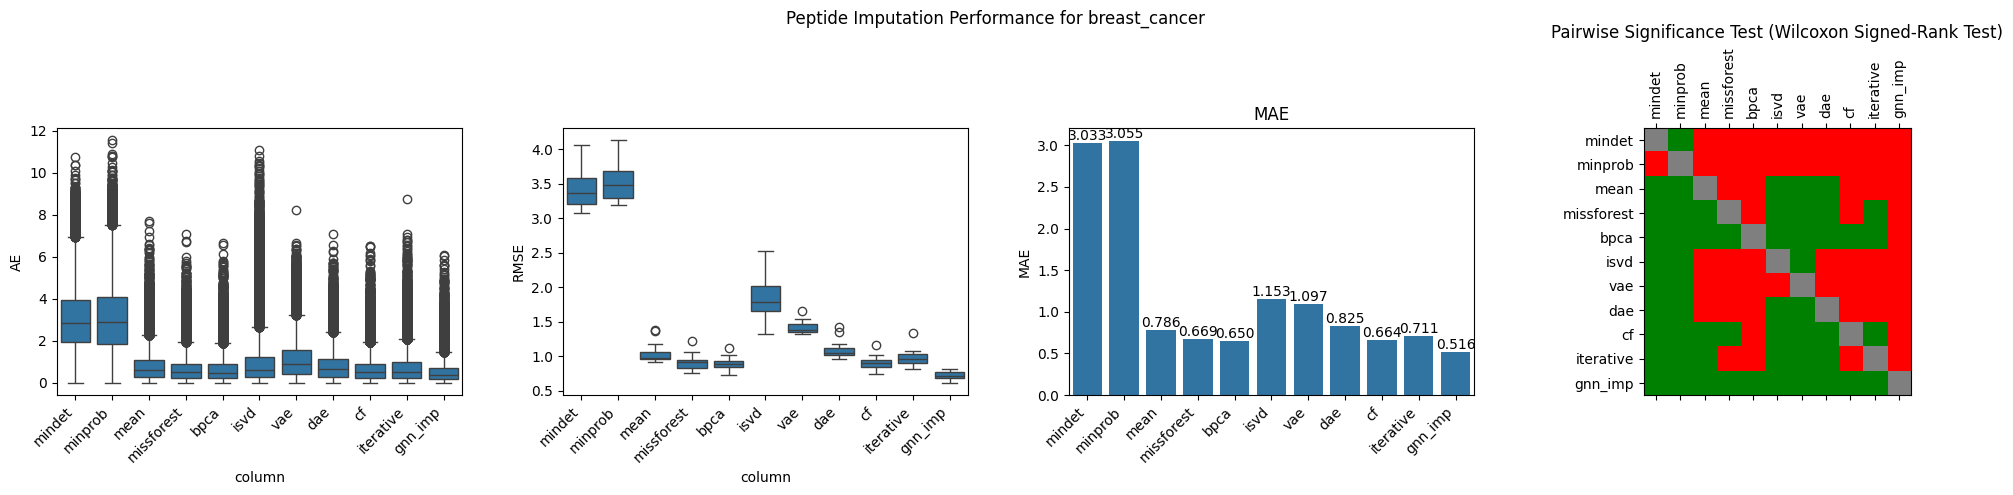

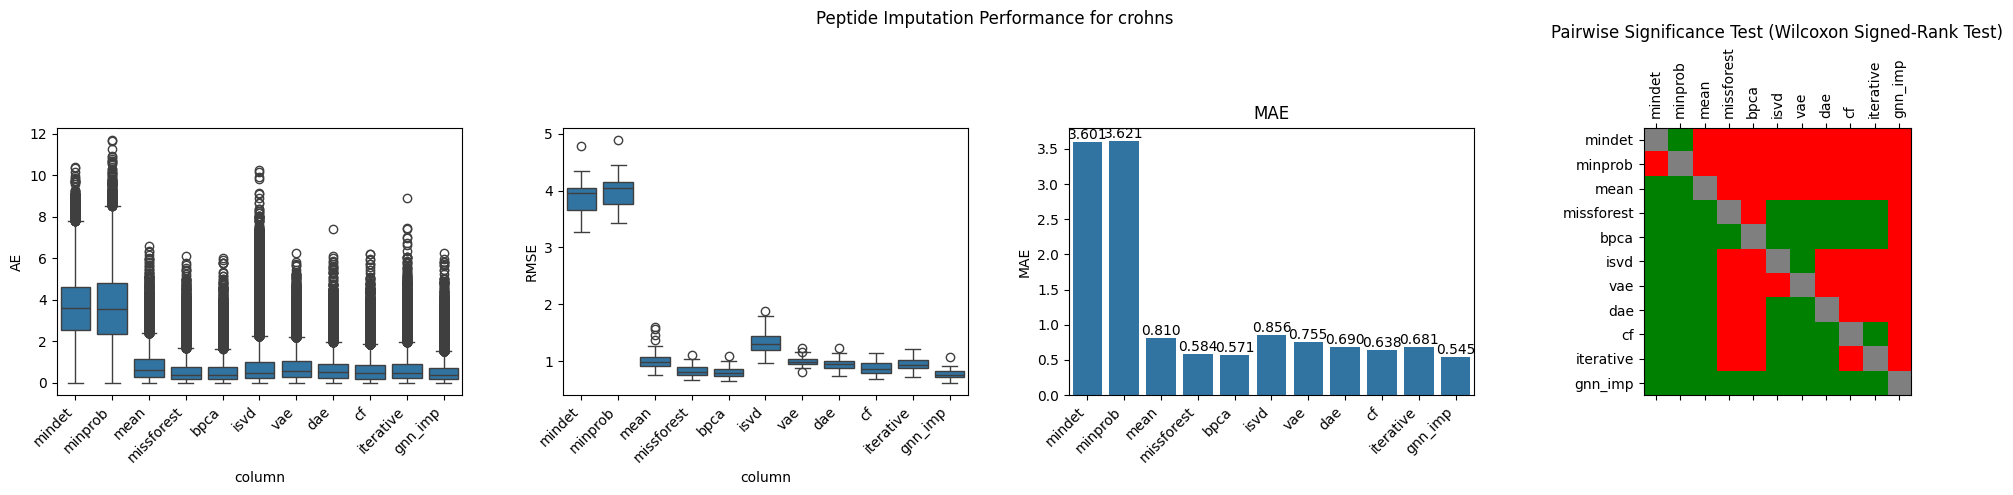

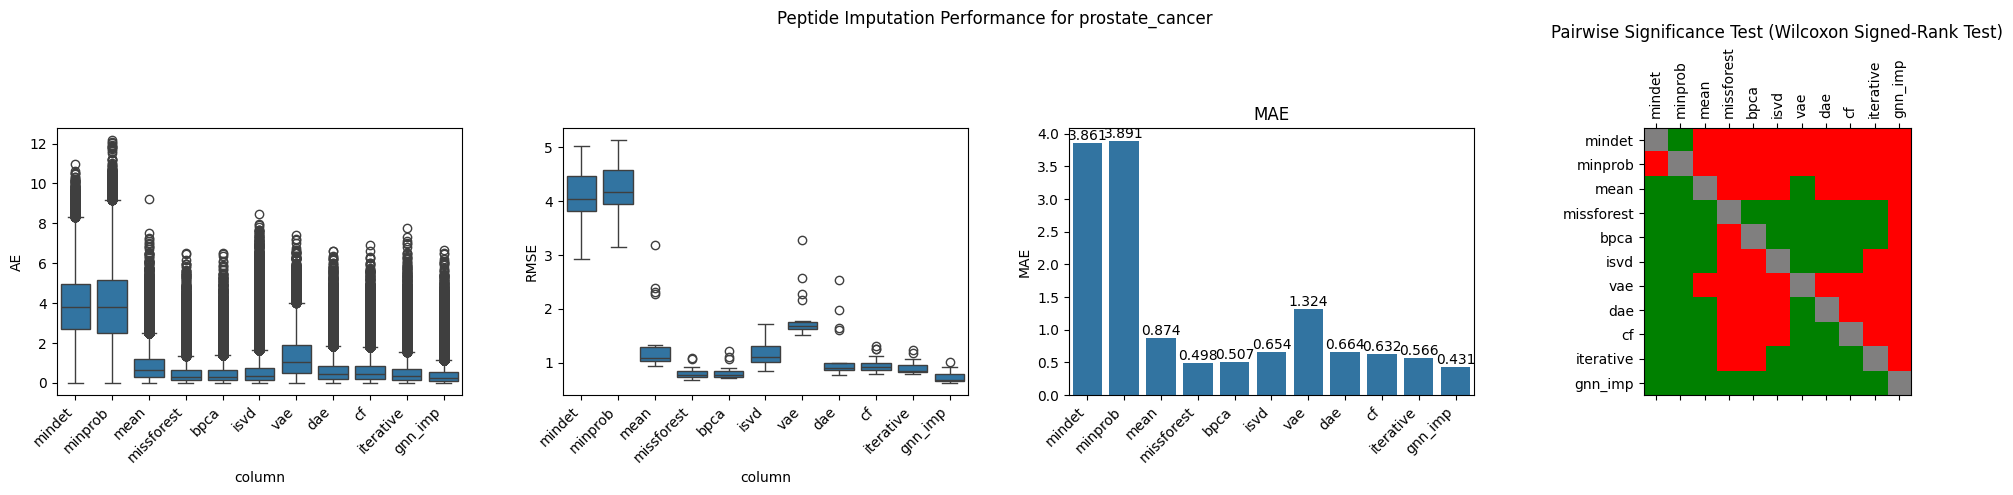

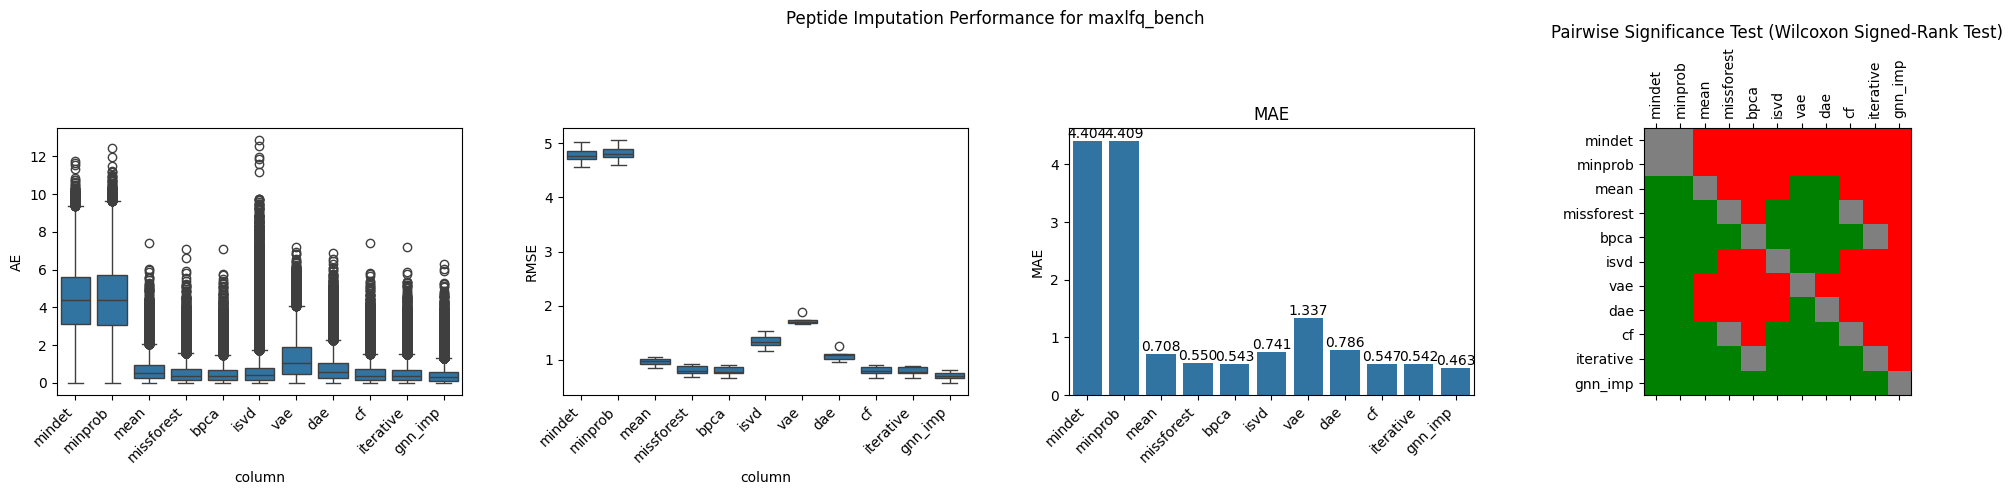

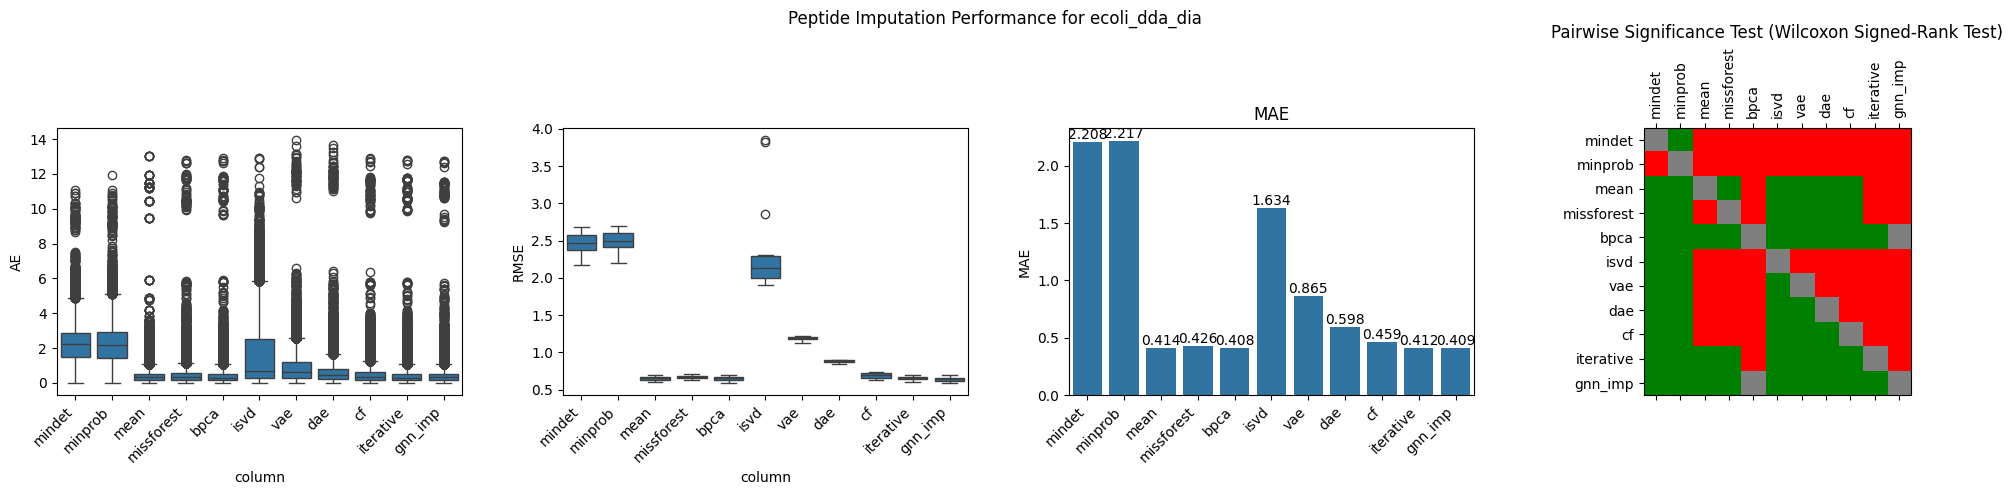

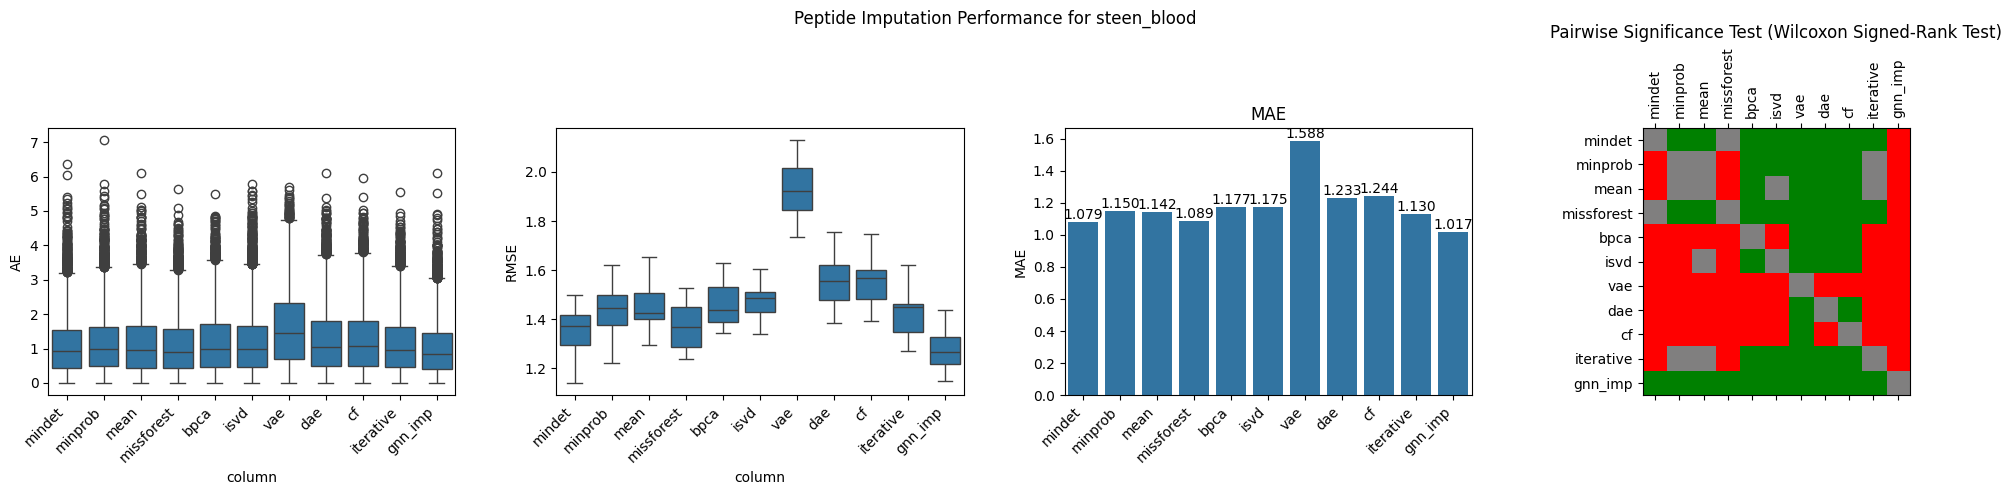

In [7]:
for ds_name, ds in datasets.items():
    not_all_missing = ds.get_wf('peptide', 'abundance')
    not_all_missing = not_all_missing[not_all_missing.count(axis=1) > 0].index
    gt_column = gt_columns[ds_name]
    ids = ds.values['peptide'][gt_column]
    ids = ids[~ids.isna() & ds.values['peptide']['abundance'].isna()].index
    ids = ids[ids.get_level_values('id').isin(not_all_missing)]
    df= ds.values['peptide'].df.loc[ids, eval_columns]
    df = df[~df.isna().any(axis=1)]
    fig, axs = plt.subplots(1, 4, figsize=(20, 5))
    axs = axs.flatten()
    # molecule AE and sample wise RMSE plots
    fig.suptitle(f'Peptide Imputation Performance for {ds_name}')
    for metric, ax in zip(['AE', 'RMSE'], axs):
        metric_df = compare_columns(dataset=ds, molecule='peptide', columns=eval_columns, comparison_column=gt_column,
                                    metric=metric, logarithmize=False, ids=ids, per_sample=True, ignore_missing=False)
        boxplot(data=metric_df, x='column', y='metric', ax=ax)
        ax.set_ylabel(metric)
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    # Dataset AE barplot 
    df = ds.values['peptide'].df
    df = df.loc[ids]
    ae = ((df - df[[gt_column]].values).abs())
    ae = ae[eval_columns]
    mae = ae.mean()
    ax = axs[2]
    sns.barplot(mae, ax=ax)
    ax.set_xticklabels(mae.index, rotation=45, ha='right')
    ax.bar_label(ax.containers[0], fontsize=10, fmt='%.3f')
    ax.set_ylabel('MAE')
    ax.set_title('MAE')
    #print(((df - df[[gt_column]].values)**2).mean())
    paired_wilcoxon_matrix(dataset=ds, molecule='peptide', eval_columns=eval_columns, gt_column=gt_column, ax=axs[3], ids=ids)
    axs[3].set_title('Pairwise Significance Test (Wilcoxon Signed-Rank Test)')
    fig.tight_layout()

/tmp/ipykernel_334404/4155626566.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/tmp/ipykernel_334404/4155626566.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/tmp/ipykernel_334404/4155626566.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/tmp/ipykernel_334404/4155626566.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


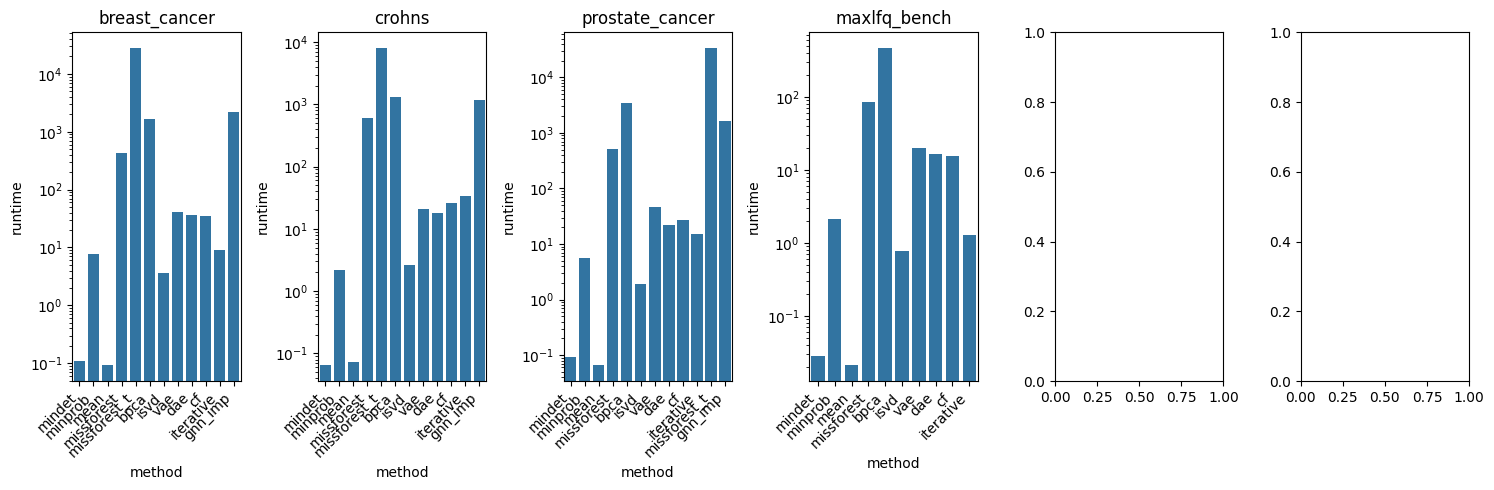

In [20]:
import json
pep_runtimes = {}
with open('runtimes/runtimes_pep.json', 'r') as f:
    pep_runtimes = json.load(f)
with open('runtimes/runtimes_gnn.json', 'r') as f:
    gnn_runtimes = json.load(f)
    for k,v in gnn_runtimes.items():
        pep_runtimes[k].update(v)

fig, axs = plt.subplots(1, len(datasets), figsize=(15, 5))
axs = axs.flatten()
for i, (ds_name, ds) in enumerate(datasets.items()):
    if ds_name not in pep_runtimes:
        continue
    ax = axs[i]
    runtimes = pep_runtimes[ds_name]
    runtimes = pd.DataFrame(index=runtimes.keys(), data={'runtime': runtimes.values()}).reset_index()
    runtimes['method'] = runtimes['index']
    runtimes['runtime'] = runtimes['runtime'].astype(float)
    sns.barplot(runtimes, x='method', y='runtime', ax=ax)
    ax.set_title(ds_name)
    ax.set_yscale('log')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
fig.tight_layout()

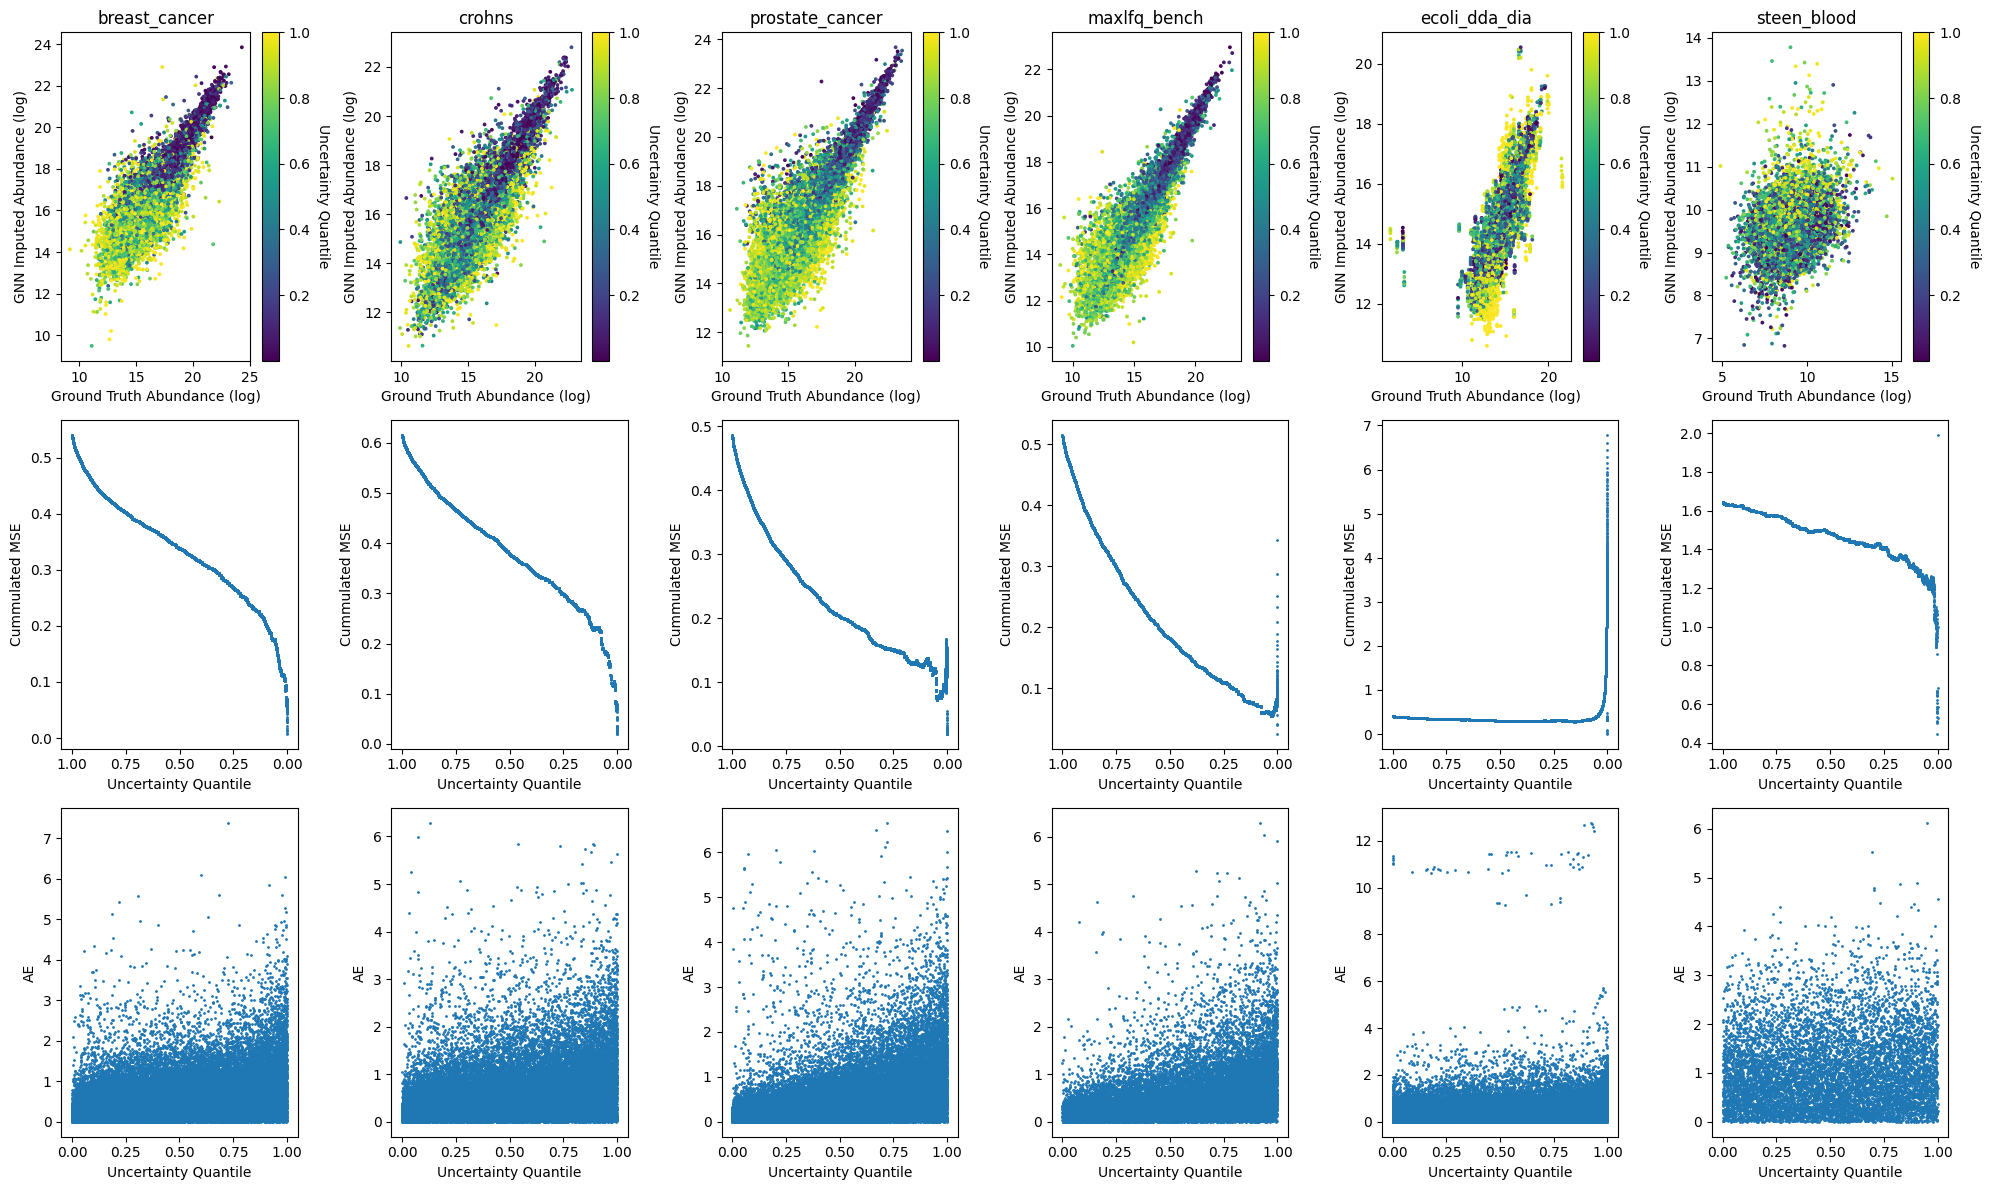

In [10]:
import pandas as pd
from matplotlib import pyplot as plt
fig, axs = plt.subplots(3, len(datasets), figsize=(20, 12))
axs = axs.transpose().flatten()
for i, (ds_name, ds) in enumerate(datasets.items(),):
    df = ds.values['peptide'].df
    gt_column = gt_columns[ds_name]
    gt =df[gt_column]
    mask = df['abundance'].isna() &  ~gt.isna()
    gt = gt[mask]
    gnn = df[f'gnn_imp']
    gnn = gnn[mask]
    uncertainty = df[f'gnn_imp_var']
    uncertainty = uncertainty[mask]
    diff = (gt - gnn).abs()
    se  = (gt - gnn)**2
    df = pd.DataFrame({'gt':gt, 'gnn':gnn, 'ae':diff, 'se':se, 'uncertainty':uncertainty})
    df['ae_rank'] = df.ae.rank()
    df['uncertainty_rank'] = df.uncertainty.rank() / df.shape[0]
    ax = axs[3 * i]
    mappable = ax.scatter(gt, gnn, c=df.uncertainty_rank, s=3)
    #mappable = ax.scatter(np.abs(gt-gnn), np.log(uncertainty), s=5)
    #ax.set_title(f'{ds_name_map[ds_name]}, {agg} aggregation')
    ax.set_xlabel('Ground Truth Abundance (log)')
    ax.set_ylabel('GNN Imputed Abundance (log)')
    cbar = plt.colorbar(mappable=mappable)
    cbar.set_label('Uncertainty Quantile', rotation=-90, verticalalignment='bottom')
    df = df.sort_values('uncertainty', ascending=True)
    df['mae'] = df['ae'].cumsum() / np.arange(1, df.shape[0]+1)
    df['mse'] = df['se'].cumsum() / np.arange(1, df.shape[0]+1)
    ax.set_title(ds_name)
    ax = axs[3 * i + 1]
    ax.scatter(df.uncertainty_rank, df['mse'], s=1)
    ax.set_xlim(ax.get_xlim()[::-1])
    #ax.scatter(df['ae'], np.log(df['uncertainty']), s=1)
    ax.set_xlabel('Uncertainty Quantile')
    ax.set_ylabel('Cummulated MSE')

    ax = axs[3 * i + 2]
    ax.scatter(df.uncertainty_rank, df['ae'], s=1)
    ax.set_xlabel('Uncertainty Quantile')
    ax.set_ylabel('AE')
    #ax.scatter(df['ae'], np.log(df['uncertainty']), s=1)
    ax.set_xlabel('Uncertainty Quantile')
    #mappable = ax.scatter(df['gt'].loc[ids], df.gnn.loc[ids], c=np.log(df.uncertainty.loc[ids]), s=1, cmap='inferno')
    #plt.colorbar(mappable)
fig.tight_layout()

/hpi/fs00/home/tobias.pietz/MasterThesis/results/outlook/../../evaluation/ratios.py:79: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation=45, ha="right")
/hpi/fs00/home/tobias.pietz/MasterThesis/results/outlook/../../evaluation/ratios.py:79: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation=45, ha="right")
/hpi/fs00/home/tobias.pietz/MasterThesis/results/outlook/../../evaluation/ratios.py:79: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation=45, ha="right")


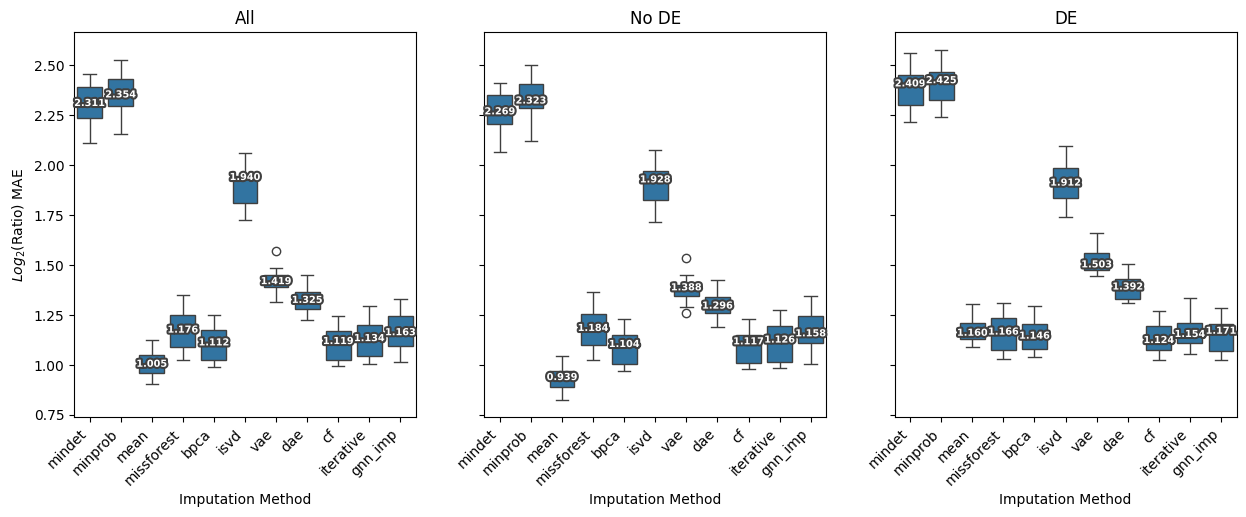

In [9]:
from evaluation.ratios import plot_ratio_mae
from pyproteonet.visualization.ratios import plot_ratio_scatter
from evaluation.ground_truth_evaluation import _add_median_labels
dfs = dict()
eval_columns = PEPTIDE_IMPUTATION_METHODS + ['gnn_imp']

dfs = dict()
for ds_name, ds in datasets.items():
    if ds_name != 'maxlfq_bench':
        continue
    ecoli_ids = ds.molecules['peptide']
    ecoli_ids = ecoli_ids[ecoli_ids.is_ecoli].index
    gt_ratio = pd.Series(index=ds.molecules['peptide'].index, data=1)
    gt_ratio[ds.molecules['peptide'].is_ecoli] = 3
    fig, df = plot_ratio_mae(dataset = ds, molecule = 'peptide', columns = eval_columns, numerator_samples = ['H1','H2','H3'], denominator_samples = ['L1','L2','L3'],
                             ground_truth_ratios = gt_ratio, is_log=True, fc_thresh = 1.5, return_df=True,
                             calculate_log2_ratio=True)
    for ax in fig.axes:
        _add_median_labels(ax=ax, fmt=".3f", fontsize=7)
        ax.set_ylabel('$Log_2$(Ratio) MAE')

In [12]:
from typing import Optional, List
from pyproteonet.metrics.differential_expression import find_des, evaluate_des
from pyproteonet.visualization.differential_expression import plot_des_volcano
import math
numerator_samples = ['H1','H2','H3']
denominator_samples = ['L1','L2','L3']
fc_thresh = 1.5

from typing import Optional
def plot_eval_des(ds, molecule, columns, ref_column, numerator_samples, denominator_samples, save_dir=None, separate_figs: bool = False, 
                  groups: Optional[List[str]] = None, ylim=None):
    if not separate_figs:
        fig, axs = plt.subplots(2, 1, figsize=(12, 16))
        i=0
    if groups is not None:
        assert len(groups) == len(columns)
    if separate_figs:
        fig, axs = plt.subplots(1, 1, figsize=(20, 8))
        axs = [axs]
        i=0
    is_ecoli = ds.molecules[molecule].is_ecoli
    categories = pd.Series(index=is_ecoli.index, data='')
    categories.loc[is_ecoli] = 'E. coli'
    categories.loc[~is_ecoli] = 'Human'
    gt_fc = pd.Series(index=categories.index, data=1)
    gt_fc.loc[categories == 'E. coli'] = 3
    de_res = []
    res = evaluate_des(dataset=ds, molecule=molecule, columns=columns + [ref_column], numerator_samples=numerator_samples,
                       denominator_samples=denominator_samples, gt_fc=gt_fc,
                       min_fc=fc_thresh, max_pvalue=0.05, is_log=True, absolute_metrics=False)
    res['Method'] = res.index
    res['run'] = 0
    res.loc[:, ['Recall', 'Precision', 'Specificity', 'Accuracy', 'FP Rate', 'F1 Score']] = (res[['Recall', 'Precision', 'Specificity', 'Accuracy', 'FP Rate', 'F1 Score']] - res.loc[ref_column])
    de_res.append(res)
    de_res = pd.concat(de_res, ignore_index=True)
    #de_res.loc[:, ['Correct DE', 'Correct no DE', 'Correctly Classified', 'False Positives']] = (de_res[['Correct DE', 'Correct no DE', 'Correctly Classified', 'False Positives']] - de_res.loc['aggregated'])
    de_res.rename(columns={'F1 Score': 'F₁ Score'}, inplace=True)
    de_res = de_res.melt(id_vars=['Method'], value_vars=['Recall', 'Precision', 'Specificity', 'Accuracy', 'FP Rate', 'F₁ Score'], value_name='%', var_name='Metric')
    if groups is not None:
        groups_map = {c:g for c,g in zip(columns, groups)}
        de_res['Metric'] = de_res['Metric'] + ' ' + de_res['Method'].map(groups_map)
    #de_res['Method'] = de_res['Method'].map(column_label_map)
    #de_res = de_res.melt(id_vars=['Method'], value_vars=['Correct DE', 'Correct no DE', 'Correctly Classified', 'False Positives'], value_name='%', var_name='Metric')
    ax = axs[i]
    sns.barplot(data=de_res, x='Method', y='%', hue='Metric', ax=ax)
    for con in ax.containers:
        ax.bar_label(con, fmt='%.3f')
    if i==0:
        ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2), ncol=3, fancybox=True, shadow=True)
    else:
        ax.legend().remove()
    i+=1
    ax.set_xticklabels(labels=ax.get_xticklabels(), rotation=45, ha='right')
    ax.set_xlabel('')
    fig.tight_layout()
    return de_res

/tmp/ipykernel_411243/2901959704.py:53: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels=ax.get_xticklabels(), rotation=45, ha='right')


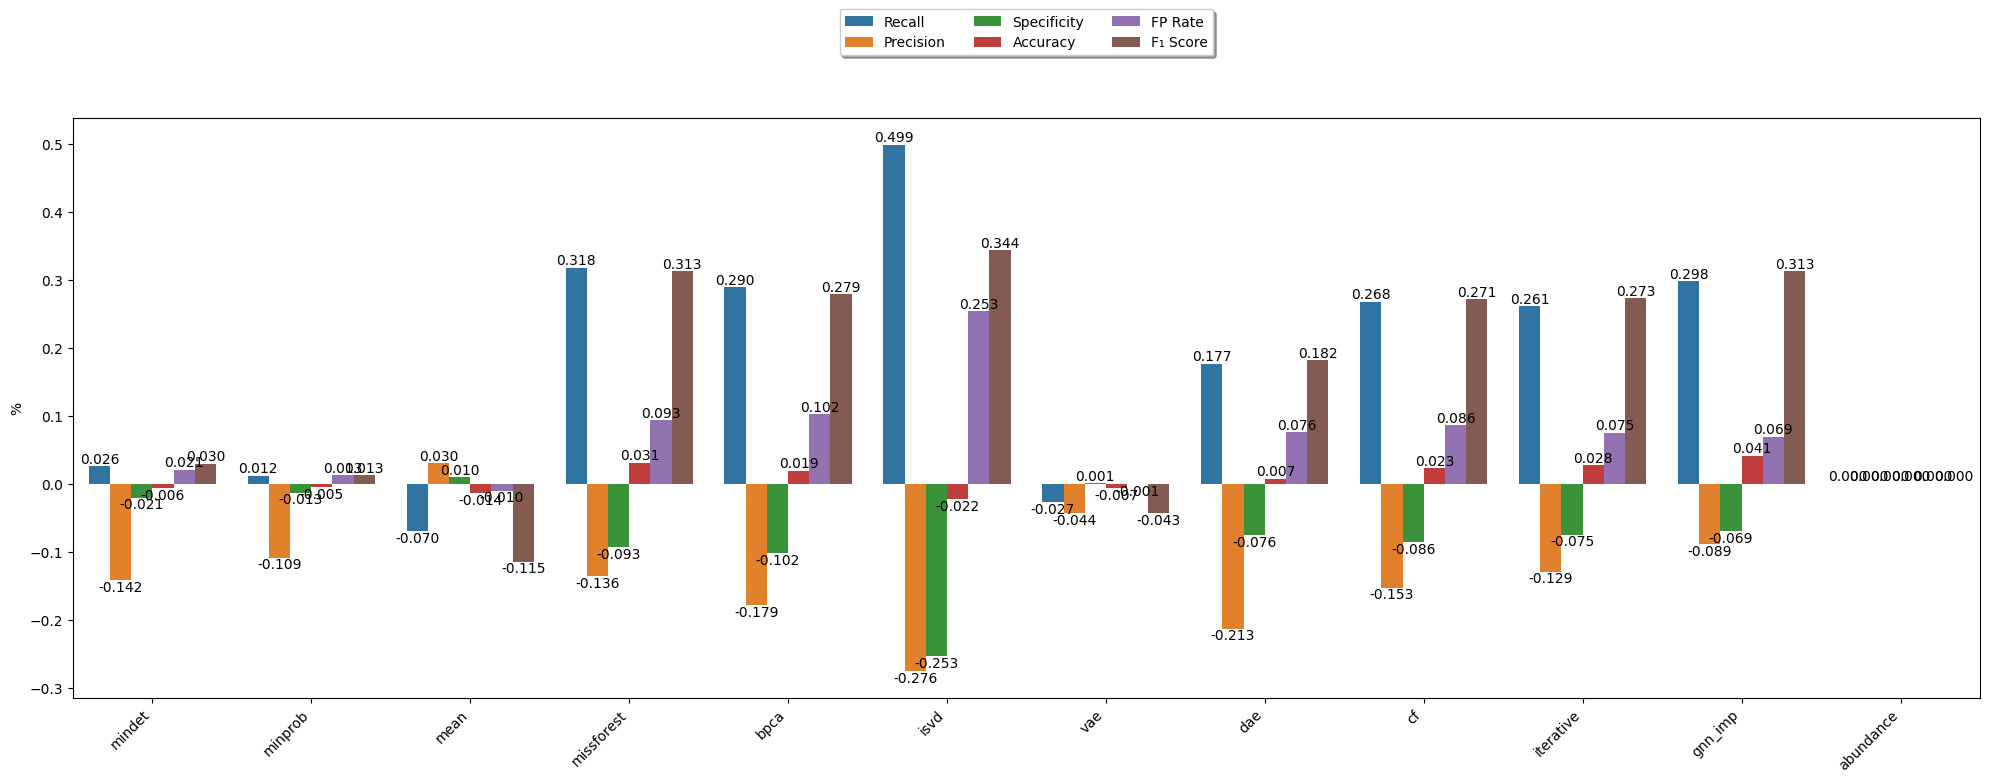

In [13]:
de_res = plot_eval_des(ds=datasets['maxlfq_bench'], molecule='peptide', columns=eval_columns, ref_column='abundance',
                       numerator_samples=numerator_samples, denominator_samples=denominator_samples, save_dir=None, separate_figs=True, ylim=(-0.6, 0.4))

In [15]:
ds = datasets['maxlfq_bench']

des, pvalues, fc = find_des(dataset=ds, molecule='peptide', columns=eval_columns,
                            nominator_samples=numerator_samples, denominator_samples=denominator_samples,
                            min_fc=1, max_pvalue=0.05, is_log=True)

In [16]:
is_ecoli = ds.molecules['peptide'].is_ecoli
categories = pd.Series(index=is_ecoli.index, data='')
categories.loc[is_ecoli] = 'E. coli'
categories.loc[~is_ecoli] = 'Human'
gt_fc = pd.Series(index=categories.index, data=1)
gt_fc.loc[categories == 'E. coli'] = 3
gt_fc[gt_fc == 1] = 0
gt_fc[gt_fc == 3] = 1

AUPRC mindet: 0.4745856560806706
AUPRC minprob: 0.48397747843872896
AUPRC mean: 0.563293034900145
AUPRC missforest: 0.5759212016012528
AUPRC bpca: 0.5643349378417746
AUPRC isvd: 0.45515015084702737
AUPRC vae: 0.5229632298776106
AUPRC dae: 0.526372064335872
AUPRC cf: 0.5556855210469972
AUPRC iterative: 0.5681221811035504
AUPRC gnn_imp: 0.6098367856777989


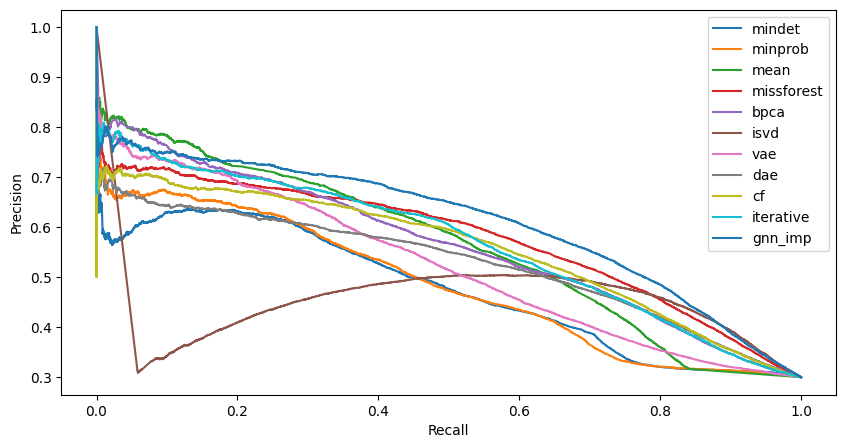

In [18]:
from sklearn.metrics import precision_recall_curve, auc

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
for c in pvalues.columns:
    precision, recall, thresholds = precision_recall_curve(y_true=gt_fc, probas_pred=1 - pvalues[c])
    ax.plot(recall, precision, label=c)
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    print(f'AUPRC {c}: {auc(recall, precision)}')
ax.legend()

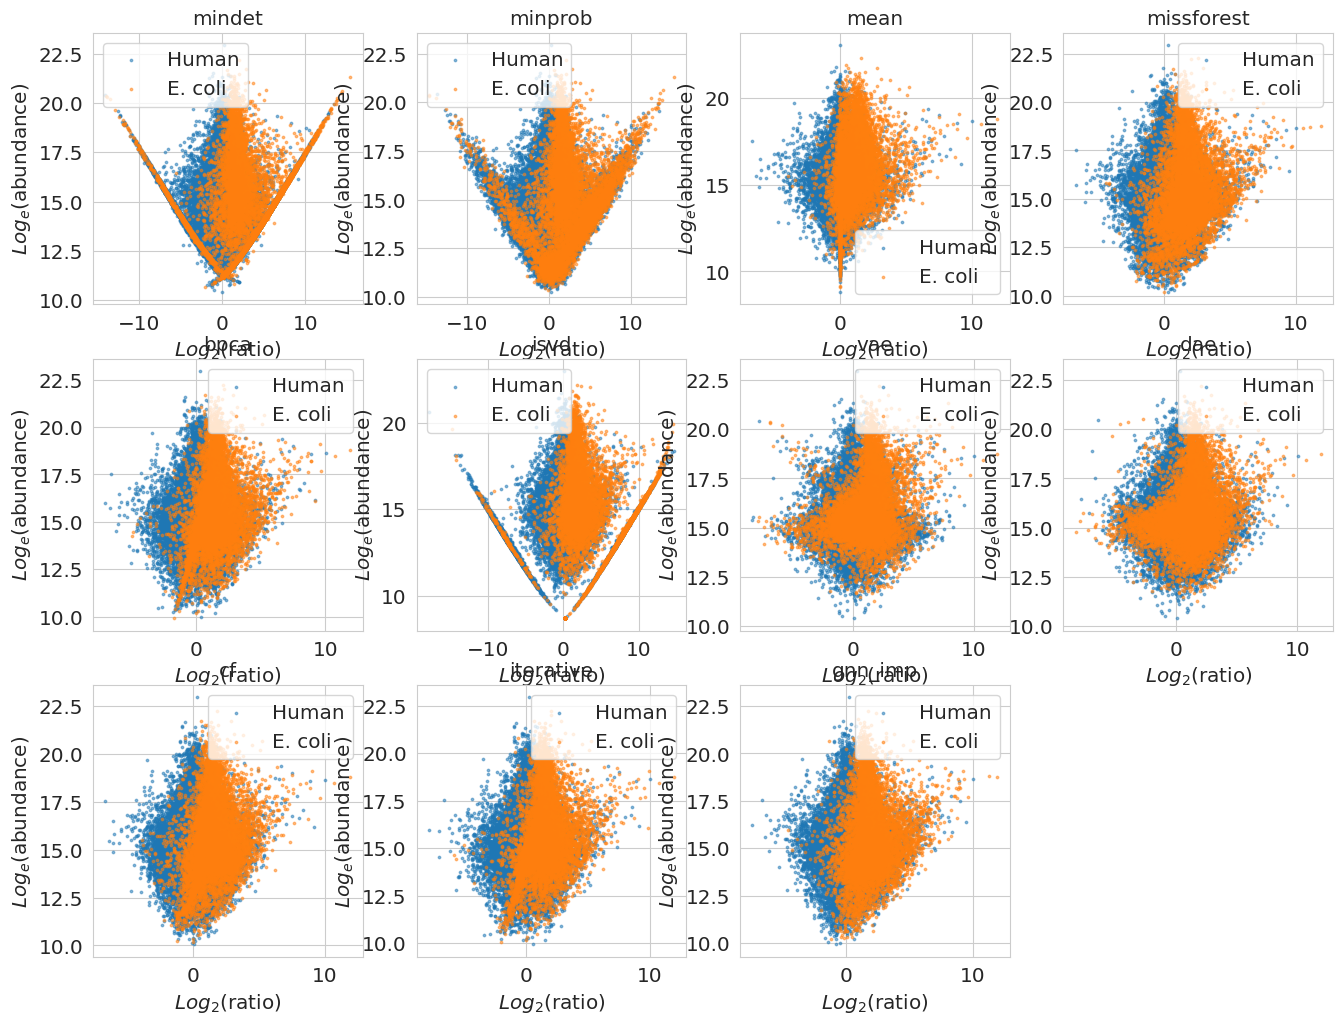

In [117]:
import math
columns_per_row = 4
numerator_samples = ['H1','H2','H3']
denominator_samples = ['L1','L2','L3']
molecule = 'peptide'

for ds_name, ds in datasets.items():
    is_ecoli = ds.molecules[molecule].is_ecoli
    categories = pd.Series(index=is_ecoli.index, data='')
    categories.loc[is_ecoli] = 'E. coli'
    categories.loc[~is_ecoli] = 'Human'
    missing_ids = ds.get_samples_value_matrix(molecule=molecule, column='abundance')
    missing_ids = missing_ids.loc[:,numerator_samples].isna().sum(axis=1) + missing_ids.loc[:,denominator_samples].isna().sum(axis=1)
    missing_ids = missing_ids[missing_ids > 0].index
    num_plots = len(eval_columns)
    num_ax_rows = math.ceil(num_plots/columns_per_row)
    fig, axs = plt.subplots(num_ax_rows, columns_per_row, figsize=(columns_per_row * 4, num_ax_rows * 4))
    axs = axs.flatten()
    a,b = plot_ratio_scatter(dataset=ds, molecule=molecule, columns=eval_columns,
                             categories=categories,
                             numerator_samples=numerator_samples, denominator_samples=denominator_samples, axs=axs, ids=missing_ids,
                             plot_density=False, is_log=True, s = 3, alpha=0.5)